# Genre Collaboration Network (2000-2023)

Network visualization from BigQuery co-occurrence data.

In [404]:
# Load packages
library(tidyverse)
library(igraph)
library(GGally)
library(network)
library(sna)
library(intergraph)
library(patchwork)

theme_set(theme_minimal())

## Load Data

In [405]:
# Load co-occurrence network
edges_all <- read_csv(
  '../../data/sql_query_out/QUERY 2_ Genre Co-Occurrence Network (All Time).csv',
  show_col_types = FALSE
) %>%
  rename(from = genre_1, to = genre_2, weight = co_occurrence_count) %>%
  filter(from != to, weight >= 2)

cat(sprintf('%d genre connections loaded\n', nrow(edges_all)))

edges_all %>% arrange(desc(weight)) %>% head(10)

8597 genre connections loaded


from,to,weight
<chr>,<chr>,<dbl>
hip hop,rap,287
pop rap,rap,273
dance pop,pop,268
mellow gold,soft rock,243
album rock,rock,239
pop rap,southern hip hop,237
r&b,urban contemporary,224
hip hop,pop rap,218
rap,southern hip hop,213


In [406]:
# Load genre mapping
genre_mapping <- read_csv(
  '../../data/sql_query_out/QUERY 5_ Genre to Main Genre Mapping (For Node Coloring).csv',
  show_col_types = FALSE
) %>%
  mutate(primary_main_genre = tolower(trimws(primary_main_genre)))

cat(sprintf('%d subgenres mapped\n', nrow(genre_mapping)))

genre_mapping %>% count(primary_main_genre, sort = TRUE) %>% head(10)

1562 subgenres mapped


primary_main_genre,n
<chr>,<int>
alternative metal,70
alternative rock,44
alternative dance,43
album rock,36
dance pop,29
alternative country,22
latin,22
anthem worship,19
big room,18


In [407]:
# Create temporal edges file with year column for Gephi dynamic filtering
# Each unique edge pair (from, to) will have 24 rows - one per year (2000-2023)
# Weight = 0 if no connection that year, otherwise the co-occurrence count

# Load all yearly data files and combine
years <- 2000:2023

yearly_edges_list <- map(years, function(yr) {
  file_path <- sprintf('../../data/sql_query_out/QUERY 4_ Export Individual Year Networks (Example for %d).csv', yr)
  if (!file.exists(file_path)) return(NULL)
  
  read_csv(file_path, show_col_types = FALSE) %>%
    rename(from = genre_1, to = genre_2, weight = co_occurrence_count) %>%
    filter(from != to) %>%  # Remove self-loops
    mutate(year = yr)
})

yearly_edges <- bind_rows(yearly_edges_list)
cat(sprintf('Loaded %d yearly edge records\n', nrow(yearly_edges)))

# Get all unique edge pairs from the all-time network (these are canonical pairs)
all_edge_pairs <- edges_all %>%
  select(from, to) %>%
  # Ensure consistent ordering (alphabetical) to avoid duplicates
  mutate(
    genre_a = pmin(from, to),
    genre_b = pmax(from, to)
  ) %>%
  select(genre_a, genre_b) %>%
  distinct()

cat(sprintf('%d unique edge pairs in all-time network\n', nrow(all_edge_pairs)))

# Create full grid: all edge pairs × all years
temporal_grid <- expand_grid(
  all_edge_pairs,
  year = years
)

cat(sprintf('Grid size: %d edge pairs × %d years = %d rows\n', 
            nrow(all_edge_pairs), length(years), nrow(temporal_grid)))

# Normalize yearly edges to same ordering for matching
yearly_edges_normalized <- yearly_edges %>%
  mutate(
    genre_a = pmin(from, to),
    genre_b = pmax(from, to)
  ) %>%
  group_by(genre_a, genre_b, year) %>%
  summarize(weight = sum(weight), .groups = 'drop')

# Join to get weights (0 if no connection that year)
temporal_edges <- temporal_grid %>%
  left_join(yearly_edges_normalized, by = c('genre_a', 'genre_b', 'year')) %>%
  mutate(weight = ifelse(is.na(weight), 0, weight)) %>%
  rename(from = genre_a, to = genre_b)

# Summary stats
cat('\nTemporal edges summary:\n')
cat(sprintf('  Total rows: %d\n', nrow(temporal_edges)))
cat(sprintf('  Non-zero weights: %d (%.1f%%)\n', 
            sum(temporal_edges$weight > 0),
            100 * sum(temporal_edges$weight > 0) / nrow(temporal_edges)))

# Show weight distribution by year
temporal_edges %>%
  group_by(year) %>%
  summarize(
    edges_active = sum(weight > 0),
    total_weight = sum(weight),
    .groups = 'drop'
  ) %>%
  print(n = 24)

Loaded 8870 yearly edge records
8597 unique edge pairs in all-time network
Grid size: 8597 edge pairs <U+00D7> 24 years = 206328 rows

Temporal edges summary:
  Total rows: 206328
  Non-zero weights: 8035 (3.9%)
# A tibble: 24 x 3
    year edges_active total_weight
   <int>        <int>        <dbl>
 1  2000          348         1010
 2  2001          428         1258
 3  2002          417         1162
 4  2003          466         1511
 5  2004          451         1453
 6  2005          455         1598
 7  2006          383         1364
 8  2007          378         1331
 9  2008          347         1036
10  2009          331          942
11  2010          347          968
12  2011          375         1081
13  2012          305          736
14  2013          370          917
15  2014          432         1158
16  2015          454          969
17  2016          325          858
18  2017          257          756
19  2018          231          692
20  2019          174          415

## Data Enhancement: Apply Supplementary Artist Genres

The MusicoSet dataset (from 2019) has limited coverage for artists who became popular after 2019.
This section loads supplementary genre data from Spotify API and manual corrections,
then merges it with the BigQuery co-occurrence data.

**Sources:**
- BigQuery co-occurrence data (original)
- Spotify API genres for unmatched artists
- Manual genre assignments for remaining artists

After this section, `edges_all` and `temporal_edges` will contain enhanced data.

In [408]:
# Load and process supplementary artist genres
# This adds genres from Spotify API and manual corrections to improve coverage

supplementary_file <- '../../data/cleaned/supplementary_artist_genres_final.csv'

if (file.exists(supplementary_file)) {
  supplementary <- read_csv(supplementary_file, show_col_types = FALSE)
  cat(sprintf("Supplementary artists loaded: %d\n", nrow(supplementary)))
  
  # Load Billboard data for year info
  billboard <- read_csv('../../data/cleaned/billboard_24years_lyrics_spotify_bigquery.csv', show_col_types = FALSE)
  
  # Find which supplementary artists are in Billboard
  supplementary_in_billboard <- supplementary %>%
    filter(name %in% billboard$band_singer)
  
  cat(sprintf("Supplementary artists on Billboard: %d\n", nrow(supplementary_in_billboard)))
  
  # Function to extract genre pairs from an artist
  extract_genre_pairs <- function(artist_name, genres_str, year) {
    genres <- str_extract_all(genres_str, "'([^']+)'")[[1]] %>%
      str_remove_all("'")
    if (length(genres) < 2) return(NULL)
    pairs <- combn(genres, 2, simplify = FALSE)
    tibble(
      genre_1 = sapply(pairs, `[`, 1),
      genre_2 = sapply(pairs, `[`, 2),
      artist = artist_name,
      year = year
    )
  }
  
  # Join supplementary with Billboard to get years
  supplementary_with_years <- billboard %>%
    select(band_singer, year) %>%
    inner_join(supplementary_in_billboard, by = c("band_singer" = "name"))
  
  cat(sprintf("Artist-year combinations to process: %d\n", nrow(supplementary_with_years)))
  
  # Extract all genre pairs
  new_pairs_list <- list()
  for (i in 1:nrow(supplementary_with_years)) {
    row <- supplementary_with_years[i, ]
    pairs <- extract_genre_pairs(row$band_singer, row$genres, row$year)
    if (!is.null(pairs)) {
      new_pairs_list[[length(new_pairs_list) + 1]] <- pairs
    }
  }
  
  new_genre_pairs <- bind_rows(new_pairs_list)
  cat(sprintf("New genre pairs extracted: %d\n", nrow(new_genre_pairs)))
  
  HAS_SUPPLEMENTARY_DATA <- TRUE
} else {
  cat("No supplementary data file found. Using BigQuery data only.\n")
  cat("To add supplementary data, run the Spotify API cells later in this notebook.\n")
  HAS_SUPPLEMENTARY_DATA <- FALSE
}

Supplementary artists loaded: 199
Supplementary artists on Billboard: 199
Artist-year combinations to process: 419
New genre pairs extracted: 1091


In [409]:
# Merge supplementary co-occurrences with BigQuery edges

if (HAS_SUPPLEMENTARY_DATA && nrow(new_genre_pairs) > 0) {
  # Aggregate to co-occurrence counts (all time)
  new_cooccurrences_all <- new_genre_pairs %>%
    mutate(
      from = pmin(genre_1, genre_2),
      to = pmax(genre_1, genre_2)
    ) %>%
    group_by(from, to) %>%
    summarize(
      new_weight = n_distinct(artist),
      .groups = 'drop'
    )
  
  # Store original for comparison
  edges_all_original <- edges_all
  
  # Normalize and merge
  edges_normalized <- edges_all %>%
    mutate(
      from_norm = pmin(from, to),
      to_norm = pmax(from, to)
    ) %>%
    select(from = from_norm, to = to_norm, weight)
  
  edges_all <- edges_normalized %>%
    full_join(new_cooccurrences_all, by = c("from", "to")) %>%
    mutate(
      weight = ifelse(is.na(weight), 0, weight),
      new_weight = ifelse(is.na(new_weight), 0, new_weight),
      weight = weight + new_weight
    ) %>%
    filter(weight >= 2) %>%
    select(from, to, weight)
  
  cat("=== EDGES ENHANCED ===\n")
  cat(sprintf("Original edges: %d\n", nrow(edges_all_original)))
  cat(sprintf("Enhanced edges: %d\n", nrow(edges_all)))
  cat(sprintf("Total weight: %d -> %d (%.1f%% increase)\n",
              sum(edges_all_original$weight),
              sum(edges_all$weight),
              (sum(edges_all$weight) - sum(edges_all_original$weight)) / sum(edges_all_original$weight) * 100))
} else {
  cat("Using original BigQuery edges (no supplementary data).\n")
}

=== EDGES ENHANCED ===
Original edges: 8597
Enhanced edges: 8656
Total weight: 95938 -> 96315 (0.4% increase)


In [410]:
# Merge supplementary co-occurrences with temporal edges (yearly data)

if (HAS_SUPPLEMENTARY_DATA && nrow(new_genre_pairs) > 0) {
  # Aggregate new pairs by year
  new_cooccurrences_yearly <- new_genre_pairs %>%
    mutate(
      from = pmin(genre_1, genre_2),
      to = pmax(genre_1, genre_2)
    ) %>%
    group_by(from, to, year) %>%
    summarize(
      new_weight = n_distinct(artist),
      .groups = 'drop'
    )
  
  # Store original
  temporal_edges_original <- temporal_edges
  
  # Merge
  temporal_edges <- temporal_edges %>%
    full_join(new_cooccurrences_yearly, by = c("from", "to", "year")) %>%
    mutate(
      weight = ifelse(is.na(weight), 0, weight),
      new_weight = ifelse(is.na(new_weight), 0, new_weight),
      weight = weight + new_weight
    ) %>%
    select(from, to, year, weight)
  
  cat("=== TEMPORAL EDGES ENHANCED ===\n")
  cat(sprintf("Original records: %d\n", nrow(temporal_edges_original)))
  cat(sprintf("Enhanced records: %d\n", nrow(temporal_edges)))
  
  # Show improvement by year
  yearly_comparison <- temporal_edges_original %>%
    group_by(year) %>%
    summarize(original = sum(weight), .groups = 'drop') %>%
    left_join(
      temporal_edges %>% group_by(year) %>% summarize(enhanced = sum(weight), .groups = 'drop'),
      by = 'year'
    ) %>%
    mutate(pct_increase = (enhanced - original) / original * 100)
  
  cat("\nYearly improvement:\n")
  print(yearly_comparison, n = 24)
} else {
  cat("Using original BigQuery temporal edges (no supplementary data).\n")
}

=== TEMPORAL EDGES ENHANCED ===
Original records: 206328
Enhanced records: 206645

Yearly improvement:
# A tibble: 24 x 4
    year original enhanced pct_increase
   <dbl>    <dbl>    <dbl>        <dbl>
 1  2000     1010     1044        3.37 
 2  2001     1258     1285        2.15 
 3  2002     1162     1184        1.89 
 4  2003     1511     1538        1.79 
 5  2004     1453     1473        1.38 
 6  2005     1598     1610        0.751
 7  2006     1364     1383        1.39 
 8  2007     1331     1349        1.35 
 9  2008     1036     1049        1.25 
10  2009      942      957        1.59 
11  2010      968      978        1.03 
12  2011     1081     1099        1.67 
13  2012      736      754        2.45 
14  2013      917      931        1.53 
15  2014     1158     1165        0.604
16  2015      969      973        0.413
17  2016      858      891        3.85 
18  2017      756      762        0.794
19  2018      692      701        1.30 
20  2019      415      446        7.47

## Build Network

In [411]:
# Build node list with macro genre mapping
all_genres <- unique(c(edges_all$from, edges_all$to))

# Load complete mapping (regex + manual assignments)
macro_mapping <- read_csv('../../data/cleaned/genre_network_mapping.csv', show_col_types = FALSE)

nodes <- tibble(name = all_genres) %>%
  left_join(genre_mapping %>% select(sub_genre, artist_count),
            by = c('name' = 'sub_genre')) %>%
  left_join(macro_mapping, by = c('name' = 'micro_genre')) %>%
  mutate(
    artist_count = ifelse(is.na(artist_count), 1, artist_count),
    macro_genre = ifelse(is.na(macro_genre), 'OTHER', macro_genre)
  )

cat(sprintf('%d nodes, %d edges\n', nrow(nodes), nrow(edges_all)))
cat('\nMacro genre distribution:\n')
nodes %>% count(macro_genre, sort = TRUE) %>% print(n = 20)

976 nodes, 8656 edges

Macro genre distribution:
# A tibble: 16 x 2
   macro_genre     n
   <chr>       <int>
 1 ROCK          239
 2 POP           129
 3 ELECTRONIC     93
 4 METAL          86
 5 HIP HOP        80
 6 R&B            62
 7 OTHER          58
 8 JAZZ           45
 9 LATIN          43
10 CLASSICAL      36
11 FOLK           33
12 COUNTRY        32
13 BLUES          17
14 REGGAE         11
15 NEW AGE         8
16 AVANT-GARDE     4


## Network Setup

In [412]:
# 16 macro genre colors
macro_genre_colors <- c(
  'POP' = '#f180a6ff',
  'ELECTRONIC' = '#d31f8eff',
  'R&B' = '#FF0800',
  'HIP HOP' = '#9D2A3A',
  'REGGAE' = '#FFB627',
  'LATIN' = '#E07B00',
  'BLUES' = '#1565C0',
  'JAZZ' = '#5C9CE6',
  'ROCK' = '#2832C2',
  'METAL' = '#1F456E',
  'FOLK' = '#6B8E4E',
  'COUNTRY' = '#7bac21ff',
  'CLASSICAL' = '#7B2D8E',
  'NEW AGE' = '#B57EDC',
  'AVANT-GARDE' = '#4A235A',
  'OTHER' = '#757575'
)

# Create igraph
g <- igraph::graph_from_data_frame(edges_all, directed = FALSE, vertices = nodes)

# Convert to network object
net <- intergraph::asNetwork(g)
net %v% "genre_name" <- nodes$name
net %v% "artist_count" <- nodes$artist_count
net %v% "macro_genre" <- nodes$macro_genre

# Layout
set.seed(42)
layout <- igraph::layout_with_fr(g, weights = 1/igraph::E(g)$weight, niter = 5000) * 1.5

## Hub Genres

In [413]:
# Calculate centrality
hub_metrics <- tibble(
  genre = nodes$name,
  main_genre = nodes$macro_genre,
  artists = nodes$artist_count,
  degree = igraph::degree(g),
  strength = igraph::strength(g),
  betweenness = igraph::betweenness(g, weights = 1/igraph::E(g)$weight)
) %>%
  arrange(desc(strength))

head(hub_metrics, 20)

# Bar chart
p_hubs <- ggplot(head(hub_metrics, 25), aes(x = reorder(genre, strength), y = strength, fill = main_genre)) +
  geom_col() +
  coord_flip() +
  labs(title = 'Top 25 Hub Genres', x = NULL, y = 'Collaboration Strength', fill = 'Genre') +
  scale_fill_manual(values = macro_genre_colors) +
  theme_minimal()

ggsave('../../outputs/genre_network/genre_hubs.png', p_hubs, width = 12, height = 10, dpi = 300, bg = 'white')

genre,main_genre,artists,degree,strength,betweenness
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
rock,ROCK,234,172,4071,167533.75
folk rock,ROCK,89,105,2846,47254.00
singer-songwriter,FOLK,54,140,2742,14438.00
modern rock,ROCK,62,153,2723,60470.43
mellow gold,POP,145,96,2591,33746.00
indie rock,ROCK,69,128,2517,16615.51
folk-pop,POP,46,145,2427,29077.01
hip hop,HIP HOP,94,83,2407,34928.50
classic rock,ROCK,172,95,2390,7608.00


In [414]:
# Full network visualization - FR layout with center scaling and collision detection
library(ggraph)

set.seed(42)

# Select top 15% of nodes by artist count for labels
label_threshold <- quantile(nodes$artist_count, 0.75)
nodes_for_plot <- nodes %>%
  mutate(
    # Wrap text - replace spaces with newlines for multi-word genres
    label = ifelse(artist_count >= label_threshold, 
                   str_replace_all(name, " ", "\n"), 
                   NA_character_)
  )

# Create fresh graph
g_full <- igraph::graph_from_data_frame(edges_all, directed = FALSE, vertices = nodes_for_plot)

# Calculate layout first, then scale it to spread nodes
layout_fr <- create_layout(g_full, layout = 'fr', weights = 1/E(g_full)$weight, niter = 10000)

# Scale coordinates outward from center
center_x <- mean(layout_fr$x)
center_y <- mean(layout_fr$y)
layout_fr$x <- center_x + (layout_fr$x - center_x) * 3.5
layout_fr$y <- center_y + (layout_fr$y - center_y) * 3.5

# Collision detection - push overlapping nodes apart
# Node radius proportional to artist_count
min_size <- 2
max_size <- 18
layout_fr$radius <- min_size + (max_size - min_size) * 
  (layout_fr$artist_count - min(layout_fr$artist_count)) / 
  (max(layout_fr$artist_count) - min(layout_fr$artist_count))

# Iterative collision resolution
for (iter in 1:50) {
  moved <- FALSE
  for (i in 1:(nrow(layout_fr) - 1)) {
    for (j in (i + 1):nrow(layout_fr)) {
      dx <- layout_fr$x[j] - layout_fr$x[i]
      dy <- layout_fr$y[j] - layout_fr$y[i]
      dist <- sqrt(dx^2 + dy^2)
      min_dist <- (layout_fr$radius[i] + layout_fr$radius[j]) * 0.35  # scale factor for plot units
      
      if (dist < min_dist && dist > 0) {
        # Push nodes apart
        overlap <- min_dist - dist
        pushx <- (dx / dist) * overlap * 0.5
        pushy <- (dy / dist) * overlap * 0.5
        
        layout_fr$x[i] <- layout_fr$x[i] - pushx
        layout_fr$y[i] <- layout_fr$y[i] - pushy
        layout_fr$x[j] <- layout_fr$x[j] + pushx
        layout_fr$y[j] <- layout_fr$y[j] + pushy
        moved <- TRUE
      }
    }
  }
  if (!moved) break
}
cat(sprintf("Collision resolution: %d iterations\n", iter))

p_full <- ggraph(layout_fr) +
  geom_edge_link(alpha = 0.05, color = "gray60") +
  geom_node_point(aes(color = macro_genre, size = artist_count), alpha = 0.8) +
  geom_node_text(aes(label = label), size = 1.2, color = "#ffffffff", fontface = "bold", lineheight = 0.8) +
  scale_color_manual(values = macro_genre_colors, name = "Genre") +
  scale_size_continuous(range = c(2, 18), name = "Artists") +
  labs(title = "Billboard Genre Network (2000-2023)",
       subtitle = sprintf("%d nodes, %d edges | Top 15%% labeled", vcount(g_full), ecount(g_full))) +
  theme_void() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12, color = "gray40"),
    legend.position = "right",
    plot.margin = margin(20, 20, 20, 20)
  ) +
  coord_fixed(ratio = 1)

ggsave('../../outputs/genre_network/genre_network_full.png', p_full, 
       width = 28, height = 24, dpi = 300, bg = 'white')

cat(sprintf("Saved genre_network_full.png (%d nodes, %d edges)\n", vcount(g_full), ecount(g_full)))

Collision resolution: 50 iterations


Warning message:
"Removed 728 rows containing missing values or values outside the scale range
(`geom_text()`)."


Saved genre_network_full.png (976 nodes, 8656 edges)


## Yearly Networks

In [415]:
# Create network for a given year - FR layout with "pop" fixed at center
library(ggraph)

create_year_network_circular <- function(year_val) {
  file_path <- sprintf('../../data/sql_query_out/QUERY 4_ Export Individual Year Networks (Example for %d).csv', year_val)
  if (!file.exists(file_path)) return(NULL)
  
  edges_yr <- read_csv(file_path, show_col_types = FALSE) %>%
    rename(from = genre_1, to = genre_2, weight = co_occurrence_count) %>%
    filter(from != to, weight >= 2)
  
  if (nrow(edges_yr) == 0) return(NULL)
  
  genres_yr <- unique(c(edges_yr$from, edges_yr$to))
  nodes_yr <- nodes %>% filter(name %in% genres_yr)
  
  # Ensure "pop" is included
  if (!"pop" %in% nodes_yr$name) {
    pop_node <- nodes %>% filter(name == "pop")
    if (nrow(pop_node) > 0) {
      nodes_yr <- bind_rows(nodes_yr, pop_node)
    }
  }
  
  # Create graph with vertex attributes
  g_yr <- igraph::graph_from_data_frame(edges_yr, directed = FALSE, vertices = nodes_yr)
  
  # Set vertex attributes explicitly
  V(g_yr)$artist_count <- nodes_yr$artist_count[match(V(g_yr)$name, nodes_yr$name)]
  V(g_yr)$macro_genre <- nodes_yr$macro_genre[match(V(g_yr)$name, nodes_yr$name)]
  
  # Calculate FR layout
  set.seed(42)
  layout_mat <- igraph::layout_with_fr(g_yr, weights = 1/E(g_yr)$weight, niter = 5000)
  
  # Find "pop" and move it to center, shift all other nodes accordingly
  node_names <- V(g_yr)$name
  pop_idx <- which(node_names == "pop")
  
  if (length(pop_idx) > 0) {
    # Get pop's current position
    pop_x <- layout_mat[pop_idx, 1]
    pop_y <- layout_mat[pop_idx, 2]
    
    # Shift all nodes so pop is at origin
    layout_mat[, 1] <- layout_mat[, 1] - pop_x
    layout_mat[, 2] <- layout_mat[, 2] - pop_y
  }
  
  # Scale layout for better spread
  layout_mat <- layout_mat * 2
  
  # Create ggraph layout
  layout_df <- create_layout(g_yr, layout = 'manual', x = layout_mat[,1], y = layout_mat[,2])
  
  # Select top nodes for labels (by artist_count)
  label_threshold <- quantile(layout_df$artist_count, 0.7, na.rm = TRUE)
  layout_df$label <- ifelse(
    layout_df$artist_count >= label_threshold | layout_df$name == "pop",
    str_replace_all(layout_df$name, " ", "\n"),
    NA_character_
  )
  
  p <- ggraph(layout_df) +
    geom_edge_link(alpha = 0.1, color = "gray50") +
    geom_node_point(aes(color = macro_genre, size = artist_count), alpha = 0.85) +
    geom_node_text(aes(label = label), size = 2, color = "#333333", fontface = "bold", lineheight = 0.8) +
    scale_color_manual(values = macro_genre_colors, name = "Genre") +
    scale_size_continuous(range = c(2, 12), name = "Artists") +
    labs(title = as.character(year_val)) +
    theme_void() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
      legend.position = "none"
    ) +
    coord_fixed(ratio = 1)
  
  return(p)
}

# Key years panel now generated after animation cell (uses same layout as GIF frames)

## Temporal Edges Export for Gephi

Create a single edges file with a year column so edges can be toggled on/off by year in Gephi.

In [416]:
# Export temporal edges (sparse - only weight > 0)
temporal_edges_export <- temporal_edges %>% filter(weight > 0) %>%
  select(from, to, weight, year) %>% arrange(from, to, year)

write_csv(temporal_edges_export, '../../outputs/genre_network/non_image/genre_network_edges_temporal_gephi.csv')
cat(sprintf('Exported: %d temporal edges\n', nrow(temporal_edges_export)))

Exported: 8478 temporal edges


In [417]:
# Export edges and nodes CSVs for Gephi
dir.create('../../outputs/genre_network/non_image', showWarnings = FALSE, recursive = TRUE)

edges_export <- edges_all %>% select(from, to, weight) %>% arrange(desc(weight))
write_csv(edges_export, '../../outputs/genre_network/non_image/genre_network_edges_gephi.csv')

nodes_export <- nodes %>%
  left_join(genre_mapping %>% select(sub_genre, primary_main_genre), by = c('name' = 'sub_genre')) %>%
  select(name, primary_main_genre, artist_count, macro_genre)
write_csv(nodes_export, '../../outputs/genre_network/non_image/genre_network_nodes_gephi.csv')

cat(sprintf('Exported: %d edges, %d nodes\n', nrow(edges_export), nrow(nodes_export)))

Exported: 8656 edges, 976 nodes


## GEXF Export for Gephi Dynamic Timeline

In [418]:
# Generate GEXF file for Gephi dynamic timeline
library(xml2)

node_positions <- tibble(name = layout_fr$name, x = layout_fr$x * 100, y = layout_fr$y * 100)

gexf <- xml_new_root("gexf", xmlns = "http://gexf.net/1.3", `xmlns:viz` = "http://gexf.net/1.3/viz", version = "1.3")
meta <- xml_add_child(gexf, "meta", lastmodifieddate = format(Sys.Date(), "%Y-%m-%d"))
xml_add_child(meta, "creator", "R/tidyverse")
xml_add_child(meta, "description", "Billboard Genre Network 2000-2023 with dynamic edges")

graph <- xml_add_child(gexf, "graph", mode = "dynamic", defaultedgetype = "undirected", timeformat = "double")

node_attrs <- xml_add_child(graph, "attributes", class = "node")
xml_add_child(node_attrs, "attribute", id = "macro_genre", title = "macro_genre", type = "string")
xml_add_child(node_attrs, "attribute", id = "artist_count", title = "artist_count", type = "integer")

edge_attrs <- xml_add_child(graph, "attributes", class = "edge")
xml_add_child(edge_attrs, "attribute", id = "weight", title = "weight", type = "double")

nodes_xml <- xml_add_child(graph, "nodes")
for (i in 1:nrow(nodes)) {
  node_name <- nodes$name[i]
  pos <- node_positions %>% filter(name == node_name)
  node <- xml_add_child(nodes_xml, "node", id = node_name, label = node_name)
  if (nrow(pos) > 0) xml_add_child(node, "viz:position", x = as.character(pos$x[1]), y = as.character(pos$y[1]), z = "0")
  color_hex <- macro_genre_colors[nodes$macro_genre[i]]
  if (!is.na(color_hex)) {
    r <- strtoi(substr(color_hex, 2, 3), 16)
    g <- strtoi(substr(color_hex, 4, 5), 16)
    b <- strtoi(substr(color_hex, 6, 7), 16)
    xml_add_child(node, "viz:color", r = as.character(r), g = as.character(g), b = as.character(b))
  }
  size_val <- 5 + (nodes$artist_count[i] / max(nodes$artist_count)) * 30
  xml_add_child(node, "viz:size", value = as.character(size_val))
  attvalues <- xml_add_child(node, "attvalues")
  xml_add_child(attvalues, "attvalue", `for` = "macro_genre", value = nodes$macro_genre[i])
  xml_add_child(attvalues, "attvalue", `for` = "artist_count", value = as.character(nodes$artist_count[i]))
}

edges_xml <- xml_add_child(graph, "edges")
active_edges <- temporal_edges %>% filter(weight > 0) %>%
  group_by(from, to) %>% summarize(years_active = list(year), weights = list(weight), .groups = 'drop')

edge_id <- 0
for (i in 1:nrow(active_edges)) {
  edge <- xml_add_child(edges_xml, "edge", id = as.character(edge_id), source = active_edges$from[i], target = active_edges$to[i])
  spells <- xml_add_child(edge, "spells")
  for (yr in active_edges$years_active[[i]]) xml_add_child(spells, "spell", start = as.character(yr), end = as.character(yr + 1))
  attvalues <- xml_add_child(edge, "attvalues")
  xml_add_child(attvalues, "attvalue", `for` = "weight", value = as.character(max(active_edges$weights[[i]])))
  edge_id <- edge_id + 1
}

write_xml(gexf, '../../outputs/genre_network/non_image/genre_network_dynamic.gexf')
cat(sprintf('Exported GEXF: %d nodes, %d edges\n', nrow(nodes), nrow(active_edges)))

Exported GEXF: 976 nodes, 1822 edges


## Animated Network

In [419]:
# Animated network - Top 300 nodes with collision detection and opacity filtering
library(gganimate)

nodes_filtered <- nodes %>% arrange(desc(artist_count)) %>% head(300)
edges_filtered <- edges_all %>% filter(from %in% nodes_filtered$name & to %in% nodes_filtered$name)
g_anim <- graph_from_data_frame(edges_filtered, directed = FALSE, vertices = nodes_filtered)

set.seed(42)
layout_anim <- layout_with_fr(g_anim, weights = 1 / E(g_anim)$weight, niter = 2000)

node_pos_anim <- tibble(name = V(g_anim)$name, x = layout_anim[,1], y = layout_anim[,2]) %>%
  left_join(nodes_filtered %>% select(name, macro_genre, artist_count), by = "name")

# Scale outward
center_x <- mean(node_pos_anim$x); center_y <- mean(node_pos_anim$y)
node_pos_anim <- node_pos_anim %>% mutate(x = center_x + (x - center_x) * 5.5, y = center_y + (y - center_y) * 5.5)

# Collision detection
min_size <- 3; max_size <- 15
node_pos_anim <- node_pos_anim %>% mutate(
  radius = min_size + (max_size - min_size) * (artist_count - min(artist_count)) / (max(artist_count) - min(artist_count))
)

for (iter in 1:100) {
  moved <- FALSE
  for (i in 1:(nrow(node_pos_anim) - 1)) {
    for (j in (i + 1):nrow(node_pos_anim)) {
      dx <- node_pos_anim$x[j] - node_pos_anim$x[i]
      dy <- node_pos_anim$y[j] - node_pos_anim$y[i]
      dist <- sqrt(dx^2 + dy^2)
      min_dist <- (node_pos_anim$radius[i] + node_pos_anim$radius[j]) * 0.55
      if (dist < min_dist && dist > 0) {
        overlap <- min_dist - dist
        node_pos_anim$x[i] <- node_pos_anim$x[i] - (dx/dist) * overlap * 0.5
        node_pos_anim$y[i] <- node_pos_anim$y[i] - (dy/dist) * overlap * 0.5
        node_pos_anim$x[j] <- node_pos_anim$x[j] + (dx/dist) * overlap * 0.5
        node_pos_anim$y[j] <- node_pos_anim$y[j] + (dy/dist) * overlap * 0.5
        moved <- TRUE
      }
    }
  }
  if (!moved) break
}

node_pos_anim <- node_pos_anim %>% mutate(label = str_replace_all(name, " ", "\n"))
filtered_node_names <- node_pos_anim$name

anim_edges <- temporal_edges %>% filter(weight > 0, from %in% filtered_node_names, to %in% filtered_node_names) %>%
  left_join(node_pos_anim %>% select(name, x, y), by = c('from' = 'name')) %>% rename(x_from = x, y_from = y) %>%
  left_join(node_pos_anim %>% select(name, x, y), by = c('to' = 'name')) %>% rename(x_to = x, y_to = y) %>%
  filter(!is.na(x_from) & !is.na(x_to))

# Activity status per year
active_nodes_by_year <- bind_rows(
  anim_edges %>% select(year, genre = from),
  anim_edges %>% select(year, genre = to)
) %>% distinct() %>% mutate(is_active = TRUE)

node_pos_yearly <- expand_grid(node_pos_anim %>% select(name, x, y, macro_genre, artist_count, label), year = 2000:2023) %>%
  left_join(active_nodes_by_year, by = c("name" = "genre", "year")) %>%
  mutate(is_active = ifelse(is.na(is_active), FALSE, TRUE), node_alpha = ifelse(is_active, 0.9, 0.15))

p_anim <- ggplot() +
  geom_segment(data = anim_edges, aes(x = x_from, y = y_from, xend = x_to, yend = y_to), alpha = 0.25, color = "gray40", linewidth = 0.4) +
  geom_point(data = node_pos_yearly, aes(x = x, y = y, color = macro_genre, size = artist_count, alpha = node_alpha)) +
  geom_text(data = node_pos_yearly %>% filter(is_active), aes(x = x, y = y, label = label), size = 1.5, color = "white", fontface = "bold", lineheight = 0.8) +
  scale_color_manual(values = macro_genre_colors, name = "Genre") +
  scale_size_continuous(range = c(3, 15), guide = "none") +
  scale_alpha_identity() +
  labs(title = 'Billboard Genre Network: {closest_state}', subtitle = sprintf("%d genres | Bright = active, Faded = inactive", nrow(node_pos_anim))) +
  theme_void() +
  theme(plot.title = element_text(hjust = 0.5, size = 32, face = "bold"), plot.subtitle = element_text(hjust = 0.5, size = 16, color = "gray40"),
        legend.position = "right", plot.background = element_rect(fill = "white", color = NA), plot.margin = margin(40, 40, 40, 40)) +
  coord_fixed(ratio = 1) +
  transition_states(year, transition_length = 0, state_length = 1) + enter_appear() + exit_disappear()

anim <- animate(p_anim, nframes = 24, fps = 1/3, width = 2400, height = 2000, res = 150, renderer = gifski_renderer())
anim_save('../../outputs/genre_network/genre_network_animated.gif', anim)
cat('Saved: genre_network_animated.gif\n')

Saved: genre_network_animated.gif


In [420]:
# Key Years Panel - extracted from animated GIF frames
# Uses the same layout (node_pos_anim) and edges (anim_edges) as the animation

key_years <- c(2000, 2005, 2010, 2015, 2020, 2023)

create_key_year_frame <- function(year_val) {
  # Filter edges for this year
  edges_yr <- anim_edges %>% filter(year == year_val)
  
  # Get active nodes for this year
  active_genres <- unique(c(edges_yr$from, edges_yr$to))
  
  # Get node data for this year with activity status
  nodes_yr <- node_pos_anim %>%
    mutate(
      is_active = name %in% active_genres,
      node_alpha = ifelse(is_active, 0.9, 0.15)
    )
  
  p <- ggplot() +
    geom_segment(data = edges_yr, 
                 aes(x = x_from, y = y_from, xend = x_to, yend = y_to), 
                 alpha = 0.25, color = "gray40", linewidth = 0.4) +
    geom_point(data = nodes_yr, 
               aes(x = x, y = y, color = macro_genre, size = artist_count, alpha = node_alpha)) +
    geom_text(data = nodes_yr %>% filter(is_active), 
              aes(x = x, y = y, label = label), 
              size = 1.8, color = "white", fontface = "bold", lineheight = 0.8) +
    scale_color_manual(values = macro_genre_colors, name = "Genre") +
    scale_size_continuous(range = c(3, 15), guide = "none") +
    scale_alpha_identity() +
    labs(title = as.character(year_val)) +
    theme_void() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
      legend.position = "none"
    ) +
    coord_fixed(ratio = 1)
  
  return(p)
}

# Generate plots for key years
key_year_plots <- map(key_years, create_key_year_frame)

# Combine into panel
combined_key_years <- wrap_plots(key_year_plots, ncol = 3) +
  plot_annotation(
    title = 'Genre Network Evolution (2000-2023)',
    subtitle = sprintf('%d genres | Bright = active, Faded = inactive (same layout as animated GIF)', nrow(node_pos_anim)),
    theme = theme(
      plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5, size = 14, color = "gray40")
    )
  )

ggsave('../../outputs/genre_network/genre_network_evolution_key_years.png', combined_key_years,
       width = 28, height = 19, dpi = 300, bg = 'white')
cat("Saved genre_network_evolution_key_years.png (using GIF frames)\n")

Saved genre_network_evolution_key_years.png (using GIF frames)


## Genre Collaboration Totals

In [421]:
# Total collaborations across all years (2000-2023)
genre_totals <- temporal_edges %>% filter(weight > 0) %>%
  pivot_longer(cols = c(from, to), names_to = "role", values_to = "genre") %>%
  group_by(genre) %>% summarize(total_collaborations = sum(weight), .groups = 'drop') %>%
  left_join(nodes %>% select(name, macro_genre), by = c('genre' = 'name')) %>%
  filter(!is.na(macro_genre), macro_genre != 'OTHER') %>%
  arrange(desc(total_collaborations))

cat(sprintf('Analyzed %d genres\n', nrow(genre_totals)))
genre_totals %>% head(20)

Analyzed 282 genres


genre,total_collaborations,macro_genre
<chr>,<dbl>,<chr>
pop,3988,POP
dance pop,3692,POP
pop rap,3653,POP
rap,2998,HIP HOP
hip hop,2806,HIP HOP
southern hip hop,2214,HIP HOP
trap music,1806,HIP HOP
urban contemporary,1769,R&B
r&b,1677,R&B


Saved genre_cooccurrence_change.png

Top 10 Rises:
# A tibble: 10 x 5
   genre               macro_genre early_total late_total absolute_change
   <chr>               <chr>             <dbl>      <dbl>           <dbl>
 1 tropical house      LATIN                22        254             232
 2 uk pop              POP                 171        362             191
 3 post-teen pop       POP                 612        793             181
 4 edm                 ELECTRONIC           42        210             168
 5 electropop          POP                  66        227             161
 6 pop                 POP                1922       2066             144
 7 metropopolis        POP                   0        111             111
 8 modern country rock COUNTRY              71        172             101
 9 electro house       ELECTRONIC           16        104              88
10 atl trap            HIP HOP               0         66              66

Top 10 Drops:
# A tibble: 10 x 5
   genre

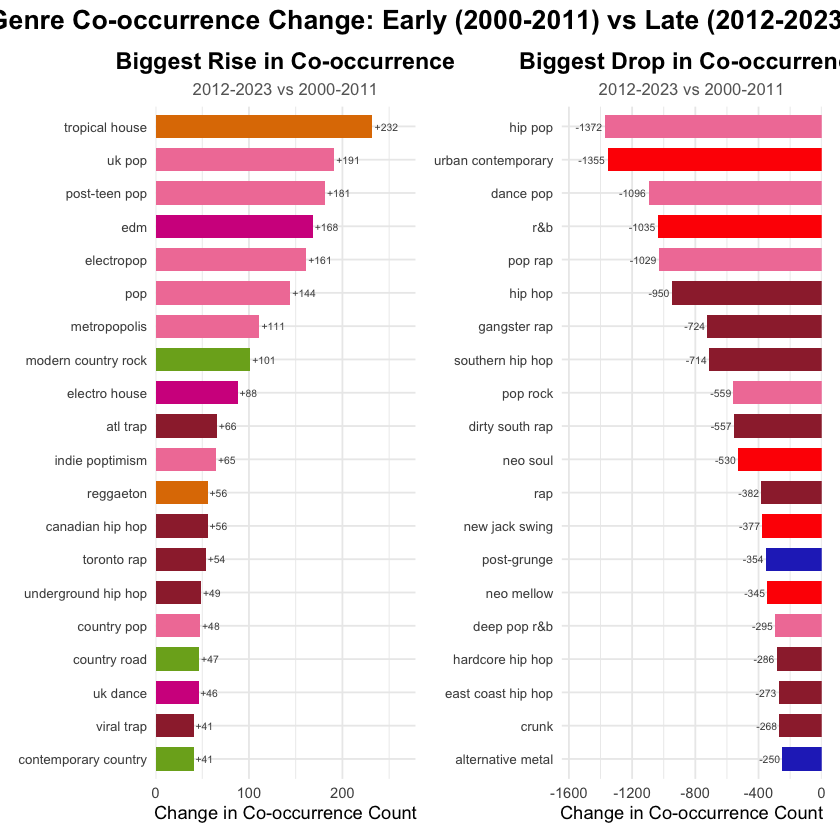

In [422]:
# Biggest Rise and Drop in Co-occurrence (Early vs Late period)
# Compare 2000-2011 vs 2012-2023

# Calculate totals for early period (2000-2011)
early_totals <- temporal_edges %>% 
  filter(weight > 0, year <= 2011) %>%
  pivot_longer(cols = c(from, to), names_to = "role", values_to = "genre") %>%
  group_by(genre) %>% 
  summarize(early_total = sum(weight), .groups = 'drop')

# Calculate totals for late period (2012-2023)
late_totals <- temporal_edges %>% 
  filter(weight > 0, year >= 2012) %>%
  pivot_longer(cols = c(from, to), names_to = "role", values_to = "genre") %>%
  group_by(genre) %>% 
  summarize(late_total = sum(weight), .groups = 'drop')

# Join and calculate change
genre_change <- early_totals %>%
  full_join(late_totals, by = "genre") %>%
  mutate(
    early_total = replace_na(early_total, 0),
    late_total = replace_na(late_total, 0),
    absolute_change = late_total - early_total,
    pct_change = ifelse(early_total > 0, (late_total - early_total) / early_total * 100, NA)
  ) %>%
  left_join(nodes %>% select(name, macro_genre), by = c('genre' = 'name')) %>%
  filter(!is.na(macro_genre), macro_genre != 'OTHER')

# Top 20 biggest rises (absolute change)
top_rises <- genre_change %>%
  filter(absolute_change > 0) %>%
  arrange(desc(absolute_change)) %>%
  head(20) %>%
  mutate(direction = "Rise")

# Top 20 biggest drops (absolute change)
top_drops <- genre_change %>%
  filter(absolute_change < 0) %>%
  arrange(absolute_change) %>%
  head(20) %>%
  mutate(direction = "Drop")

# Combine for plotting
rise_drop_data <- bind_rows(top_rises, top_drops)

# Create side-by-side plot
p_rises <- ggplot(top_rises, aes(x = reorder(genre, absolute_change), y = absolute_change, fill = macro_genre)) +
  geom_col(width = 0.7) +
  geom_text(aes(label = sprintf("+%d", absolute_change)), hjust = -0.1, size = 2.2, color = "gray30") +
  coord_flip() +
  scale_fill_manual(values = macro_genre_colors) +
  scale_y_continuous(expand = expansion(mult = c(0, 0.2))) +
  labs(title = "Biggest Rise in Co-occurrence", 
       subtitle = "2012-2023 vs 2000-2011",
       x = NULL, y = "Change in Co-occurrence Count") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 10, color = "gray40"),
    legend.position = "none",
    axis.text.y = element_text(size = 8)
  )

p_drops <- ggplot(top_drops, aes(x = reorder(genre, -absolute_change), y = absolute_change, fill = macro_genre)) +
  geom_col(width = 0.7) +
  geom_text(aes(label = sprintf("%d", absolute_change)), hjust = 1.1, size = 2.2, color = "gray30") +
  coord_flip() +
  scale_fill_manual(values = macro_genre_colors) +
  scale_y_continuous(expand = expansion(mult = c(0.2, 0))) +
  labs(title = "Biggest Drop in Co-occurrence", 
       subtitle = "2012-2023 vs 2000-2011",
       x = NULL, y = "Change in Co-occurrence Count") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 10, color = "gray40"),
    legend.position = "none",
    axis.text.y = element_text(size = 8)
  )

# Combine with shared legend
combined_rise_drop <- (p_rises | p_drops) +
  plot_annotation(
    title = "Genre Co-occurrence Change: Early (2000-2011) vs Late (2012-2023)",
    theme = theme(
      plot.title = element_text(hjust = 0.5, size = 16, face = "bold")
    )
  )

ggsave('../../outputs/genre_network/genre_cooccurrence_change.png', combined_rise_drop,
       width = 16, height = 10, dpi = 300, bg = 'white')

cat("Saved genre_cooccurrence_change.png\n")
print(combined_rise_drop)

# Also print the data
cat("\nTop 10 Rises:\n")
top_rises %>% select(genre, macro_genre, early_total, late_total, absolute_change) %>% head(10) %>% print()

cat("\nTop 10 Drops:\n")
top_drops %>% select(genre, macro_genre, early_total, late_total, absolute_change) %>% head(10) %>% print()

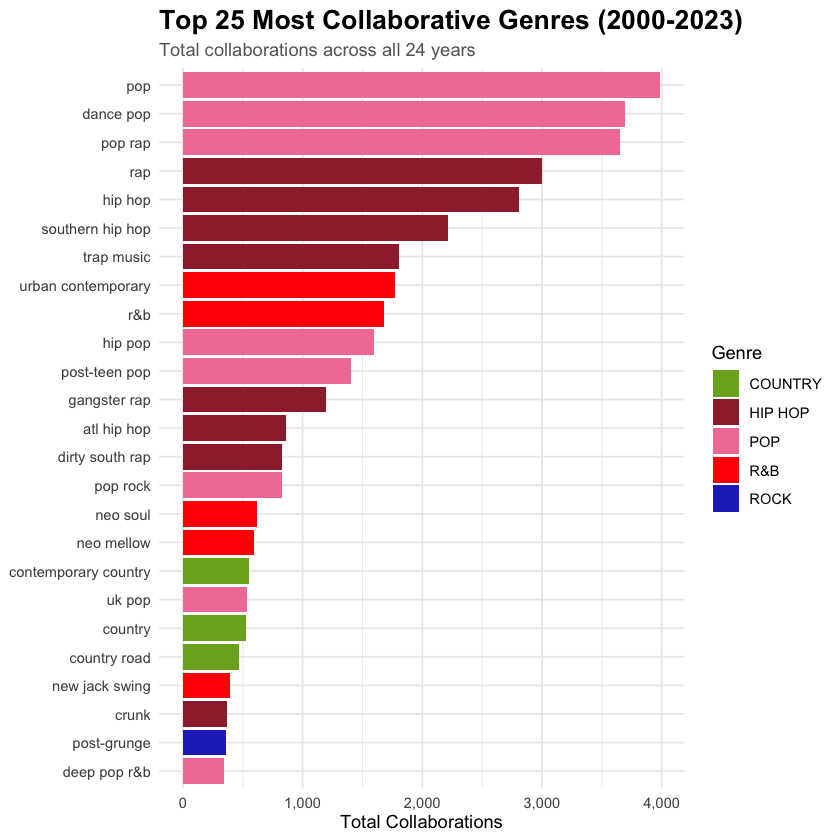

In [423]:
# Top 25 overall
top25_overall <- genre_totals %>% head(25)

p_top25 <- ggplot(top25_overall, aes(x = reorder(genre, total_collaborations), y = total_collaborations, fill = macro_genre)) +
  geom_col() + coord_flip() +
  scale_fill_manual(values = macro_genre_colors, name = "Genre") +
  scale_y_continuous(labels = scales::comma) +
  labs(title = "Top 25 Most Collaborative Genres (2000-2023)", subtitle = "Total collaborations across all 24 years", x = NULL, y = "Total Collaborations") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0, size = 16, face = "bold"),
    plot.subtitle = element_text(hjust = 0, size = 11, color = "gray40"), legend.position = "right")

ggsave('../../outputs/genre_network/top_25_collaborative_genres.png', p_top25, width = 14, height = 12, dpi = 300, bg = 'white')
print(p_top25)

## Genre Dominance Over Time

Stacked area chart showing macro-genre dominance on Billboard each year.

Saved genre_dominance_over_time.png
Saved genre_dominance_over_time_absolute.png


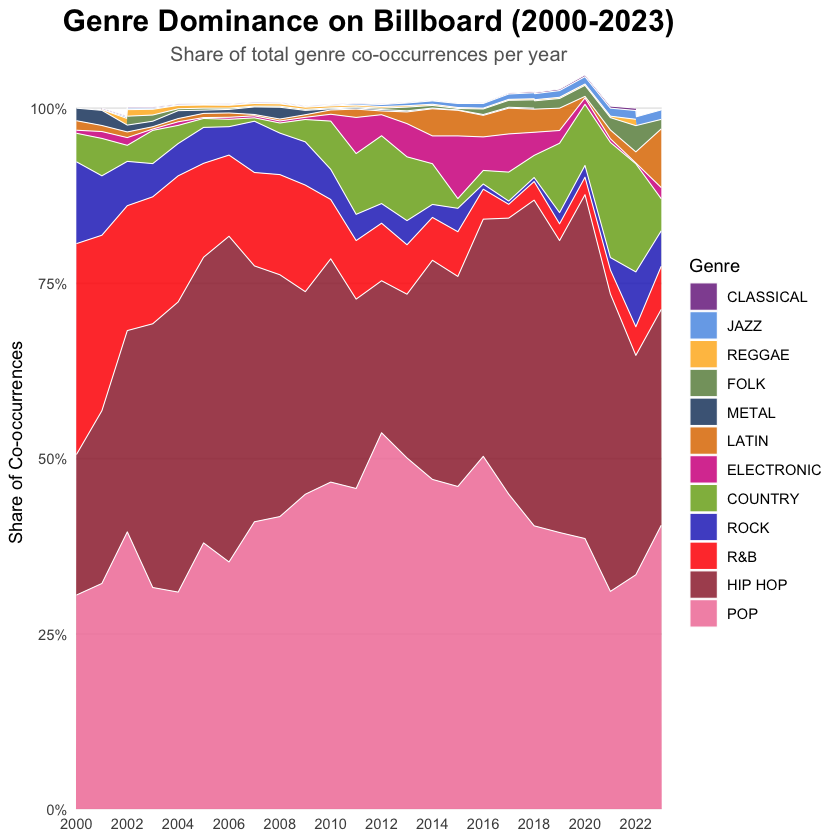

In [424]:
# Genre Dominance Over Time - Stacked Area Chart
# Shows which macro-genres dominated Billboard each year

# Calculate macro-genre presence per year from temporal edges
genre_yearly_presence <- temporal_edges %>%
  filter(weight > 0) %>%
  pivot_longer(cols = c(from, to), names_to = "role", values_to = "genre") %>%
  left_join(nodes %>% select(name, macro_genre), by = c('genre' = 'name')) %>%
  filter(!is.na(macro_genre), macro_genre != 'OTHER') %>%
  group_by(year, macro_genre) %>%
  summarize(total_weight = sum(weight), .groups = 'drop')

# Calculate percentage share per year
genre_yearly_pct <- genre_yearly_presence %>%
  group_by(year) %>%
  mutate(
    year_total = sum(total_weight),
    pct = total_weight / year_total * 100
  ) %>%
  ungroup()

# Order macro genres by total presence (for consistent stacking)
macro_order <- genre_yearly_presence %>%
  group_by(macro_genre) %>%
  summarize(total = sum(total_weight), .groups = 'drop') %>%
  arrange(desc(total)) %>%
  pull(macro_genre)

genre_yearly_pct <- genre_yearly_pct %>%
  mutate(macro_genre = factor(macro_genre, levels = rev(macro_order)))

# Stacked area chart (percentage)
p_dominance <- ggplot(genre_yearly_pct, aes(x = year, y = pct, fill = macro_genre)) +
  geom_area(alpha = 0.85, color = "white", linewidth = 0.3) +
  scale_fill_manual(values = macro_genre_colors, name = "Genre") +
  scale_x_continuous(breaks = seq(2000, 2023, by = 2), expand = c(0, 0)) +
  scale_y_continuous(labels = function(x) paste0(x, "%"), expand = c(0, 0)) +
  labs(
    title = "Genre Dominance on Billboard (2000-2023)",
    subtitle = "Share of total genre co-occurrences per year",
    x = NULL,
    y = "Share of Co-occurrences"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12, color = "gray40"),
    legend.position = "right",
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank()
  )

ggsave('../../outputs/genre_network/genre_dominance_over_time.png', p_dominance,
       width = 14, height = 8, dpi = 300, bg = 'white')

cat("Saved genre_dominance_over_time.png\n")
print(p_dominance)

# Also show the raw counts version
p_dominance_raw <- ggplot(genre_yearly_presence %>% 
                            mutate(macro_genre = factor(macro_genre, levels = rev(macro_order))), 
                          aes(x = year, y = total_weight, fill = macro_genre)) +
  geom_area(alpha = 0.85, color = "white", linewidth = 0.3) +
  scale_fill_manual(values = macro_genre_colors, name = "Genre") +
  scale_x_continuous(breaks = seq(2000, 2023, by = 2), expand = c(0, 0)) +
  scale_y_continuous(labels = scales::comma, expand = c(0, 0)) +
  labs(
    title = "Genre Co-occurrences on Billboard (2000-2023)",
    subtitle = "Total co-occurrence count per year (absolute values)",
    x = NULL,
    y = "Co-occurrence Count"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12, color = "gray40"),
    legend.position = "right",
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank()
  )

ggsave('../../outputs/genre_network/genre_dominance_over_time_absolute.png', p_dominance_raw,
       width = 14, height = 8, dpi = 300, bg = 'white')

cat("Saved genre_dominance_over_time_absolute.png\n")

## Macro-Genre Flow (Sankey/Alluvial Diagram)

Shows how genre presence shifted between early (2000-2011) and late (2012-2023) periods.

Saved genre_flow_sankey.png

Genre Flow Summary:
# A tibble: 13 x 5
   macro_genre early_total late_total change pct_change
   <chr>             <dbl>      <dbl>  <dbl>      <dbl>
 1 ELECTRONIC          237        655    418      176. 
 2 LATIN               165        480    315      191. 
 3 COUNTRY             993       1112    119       12  
 4 JAZZ                 15         33     18      120  
 5 FOLK                 88         92      4        4.5
 6 CLASSICAL             4          6      2       50  
 7 AVANT-GARDE           0          2      2      Inf  
 8 REGGAE               70         12    -58      -82.9
 9 METAL               280          8   -272      -97.1
10 ROCK               1765        383  -1382      -78.3
11 POP               11193       7469  -3724      -33.3
12 R&B                4802        824  -3978      -82.8
13 HIP HOP           10133       5643  -4490      -44.3


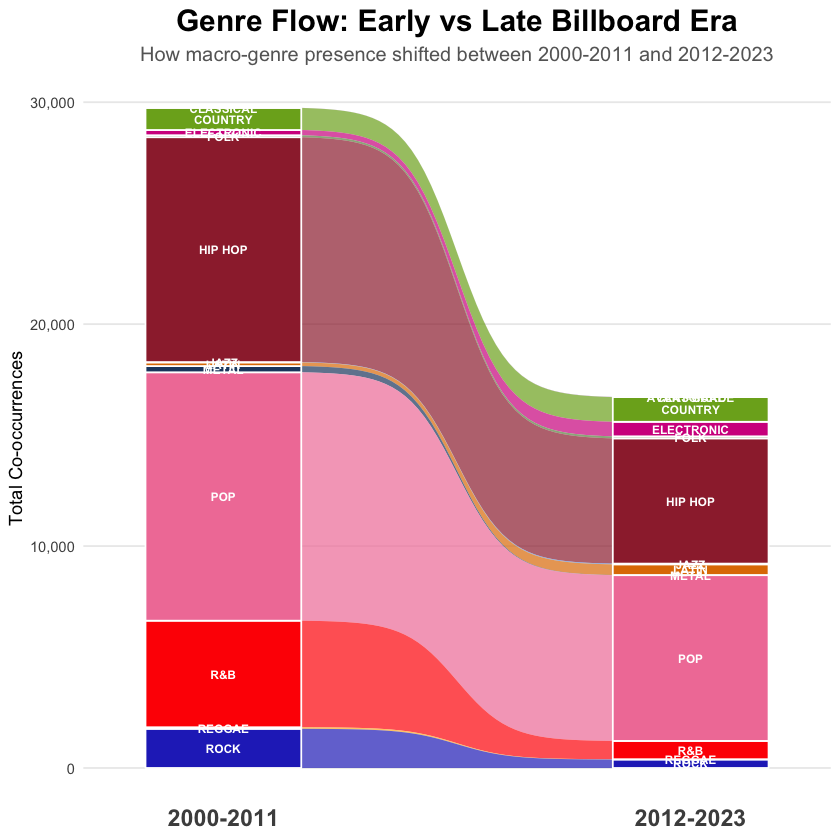

In [425]:
# Macro-Genre Flow - Sankey/Alluvial Diagram
# Shows how genre presence shifted between periods

# Install ggalluvial if needed
if (!require(ggalluvial)) {
  install.packages("ggalluvial")
  library(ggalluvial)
}

# Calculate macro-genre totals for early and late periods
early_macro <- temporal_edges %>%
  filter(weight > 0, year <= 2011) %>%
  pivot_longer(cols = c(from, to), names_to = "role", values_to = "genre") %>%
  left_join(nodes %>% select(name, macro_genre), by = c('genre' = 'name')) %>%
  filter(!is.na(macro_genre), macro_genre != 'OTHER') %>%
  group_by(macro_genre) %>%
  summarize(early_total = sum(weight), .groups = 'drop')

late_macro <- temporal_edges %>%
  filter(weight > 0, year >= 2012) %>%
  pivot_longer(cols = c(from, to), names_to = "role", values_to = "genre") %>%
  left_join(nodes %>% select(name, macro_genre), by = c('genre' = 'name')) %>%
  filter(!is.na(macro_genre), macro_genre != 'OTHER') %>%
  group_by(macro_genre) %>%
  summarize(late_total = sum(weight), .groups = 'drop')

# Combine into flow data
flow_data <- early_macro %>%
  full_join(late_macro, by = "macro_genre") %>%
  mutate(
    early_total = replace_na(early_total, 0),
    late_total = replace_na(late_total, 0)
  ) %>%
  filter(early_total > 0 | late_total > 0)

# Convert to long format for alluvial plot
flow_long <- flow_data %>%
  pivot_longer(
    cols = c(early_total, late_total),
    names_to = "period",
    values_to = "count"
  ) %>%
  mutate(
    period = factor(
      ifelse(period == "early_total", "2000-2011", "2012-2023"),
      levels = c("2000-2011", "2012-2023")
    )
  )

# Create alluvial diagram
p_sankey <- ggplot(flow_long, 
                   aes(x = period, y = count, alluvium = macro_genre, stratum = macro_genre, fill = macro_genre)) +
  geom_alluvium(alpha = 0.7, width = 1/3, curve_type = "sigmoid") +
  geom_stratum(width = 1/3, color = "white", linewidth = 0.5) +
  geom_text(stat = "stratum", aes(label = after_stat(stratum)), size = 2.5, fontface = "bold", color = "white") +
  scale_fill_manual(values = macro_genre_colors, name = "Genre") +
  scale_x_discrete(expand = c(0.15, 0.15)) +
  scale_y_continuous(labels = scales::comma) +
  labs(
    title = "Genre Flow: Early vs Late Billboard Era",
    subtitle = "How macro-genre presence shifted between 2000-2011 and 2012-2023",
    x = NULL,
    y = "Total Co-occurrences"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12, color = "gray40"),
    legend.position = "none",
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.x = element_text(size = 14, face = "bold")
  )

ggsave('../../outputs/genre_network/genre_flow_sankey.png', p_sankey,
       width = 12, height = 10, dpi = 300, bg = 'white')

cat("Saved genre_flow_sankey.png\n")
print(p_sankey)

# Print the change data
cat("\nGenre Flow Summary:\n")
flow_data %>%
  mutate(
    change = late_total - early_total,
    pct_change = round((late_total - early_total) / early_total * 100, 1)
  ) %>%
  arrange(desc(change)) %>%
  print(n = 20)

## Unique Artists on Billboard Over Time

Shows the number of unique artists appearing on Billboard each year - explaining the decline in co-occurrences.

Saved unique_artists_over_time.png

Unique Artists by Year:
# A tibble: 24 x 5
    year unique_artists total_songs total_cooccurrences pct_change_from_2000
   <dbl>          <int>       <int>               <dbl>                <dbl>
 1  2000             95         115                1044                  0  
 2  2001             96         125                1285                  1.1
 3  2002             94         134                1184                 -1.1
 4  2003            103         142                1538                  8.4
 5  2004            103         141                1473                  8.4
 6  2005             96         140                1610                  1.1
 7  2006            101         141                1383                  6.3
 8  2007             91         142                1349                 -4.2
 9  2008             88         139                1049                 -7.4
10  2009             85         130                 957                -10

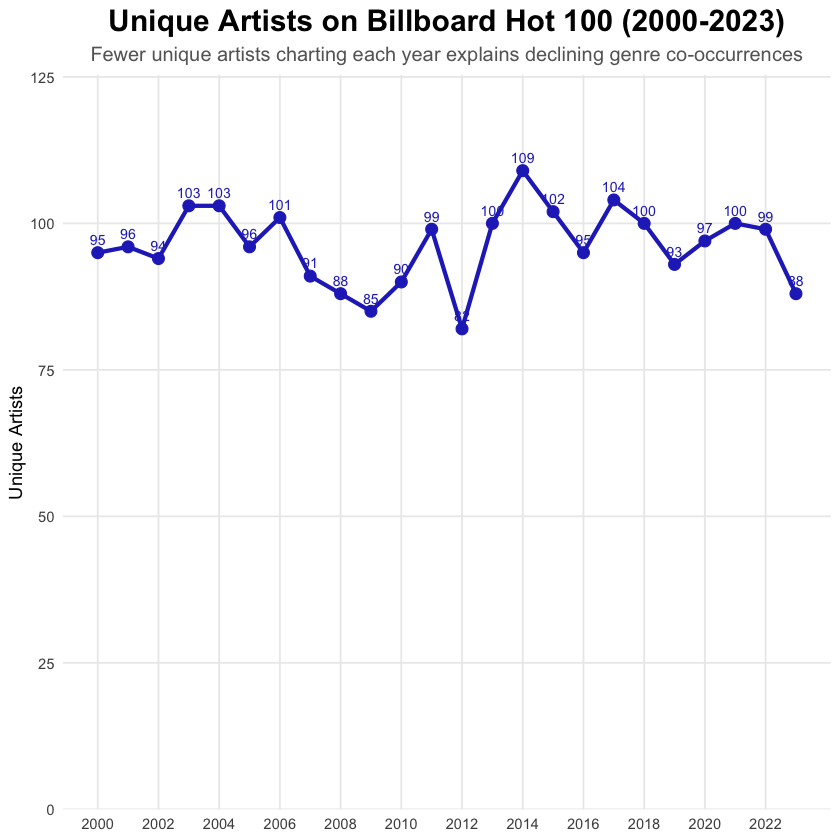

In [426]:
# Unique Artists on Billboard Over Time
# Load Billboard data to count unique artists per year

billboard <- read_csv('../../data/cleaned/billboard_24years_lyrics_spotify_bigquery.csv', show_col_types = FALSE)

# Count unique artists per year
artists_per_year <- billboard %>%
  group_by(year) %>%
  summarize(
    unique_artists = n_distinct(band_singer),
    total_songs = n(),
    .groups = 'drop'
  )

# Also get co-occurrence totals per year for comparison
cooccurrence_per_year <- temporal_edges %>%
  filter(weight > 0) %>%
  group_by(year) %>%
  summarize(total_cooccurrences = sum(weight), .groups = 'drop')

# Combine for dual-axis plot
yearly_stats <- artists_per_year %>%
  left_join(cooccurrence_per_year, by = "year")

# Create the plot
p_artists <- ggplot(yearly_stats, aes(x = year)) +
  geom_line(aes(y = unique_artists), color = "#2832C2", linewidth = 1.2) +
  geom_point(aes(y = unique_artists), color = "#2832C2", size = 3) +
  geom_text(aes(y = unique_artists, label = unique_artists), 
            vjust = -0.8, size = 3, color = "#2832C2") +
  scale_x_continuous(breaks = seq(2000, 2023, by = 2)) +
  scale_y_continuous(limits = c(0, NA), expand = expansion(mult = c(0, 0.15))) +
  labs(
    title = "Unique Artists on Billboard Hot 100 (2000-2023)",
    subtitle = "Fewer unique artists charting each year explains declining genre co-occurrences",
    x = NULL,
    y = "Unique Artists"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12, color = "gray40"),
    panel.grid.minor = element_blank()
  )

ggsave('../../outputs/genre_network/unique_artists_over_time.png', p_artists,
       width = 14, height = 8, dpi = 300, bg = 'white')

cat("Saved unique_artists_over_time.png\n")
print(p_artists)

# Print the data
cat("\nUnique Artists by Year:\n")
yearly_stats %>% 
  mutate(
    pct_change_from_2000 = round((unique_artists - first(unique_artists)) / first(unique_artists) * 100, 1)
  ) %>%
  print(n = 24)

# Summary stats
cat(sprintf("\nPeak: %d artists (%d)\n", max(yearly_stats$unique_artists), 
            yearly_stats$year[which.max(yearly_stats$unique_artists)]))
cat(sprintf("Low: %d artists (%d)\n", min(yearly_stats$unique_artists), 
            yearly_stats$year[which.min(yearly_stats$unique_artists)]))
cat(sprintf("Change 2000→2023: %.1f%%\n", 
            (yearly_stats$unique_artists[yearly_stats$year == 2023] - 
             yearly_stats$unique_artists[yearly_stats$year == 2000]) / 
             yearly_stats$unique_artists[yearly_stats$year == 2000] * 100))

## Average Genre Tags Per Artist Over Time

Shows how many genre tags each artist has on average per year.
This metric reflects both MusicoSet coverage and genre richness.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'



Average Genre Tags by Year:
# A tibble: 24 x 5
    year avg_tags median_tags total_artists artists_with_tags
   <dbl>    <dbl>       <dbl>         <int>             <int>
 1  2000     4.44         4              95                90
 2  2001     4.86         5              96                93
 3  2002     4.51         4.5            94                87
 4  2003     5.07         5             103               101
 5  2004     4.89         4             103                98
 6  2005     5.59         6              96                92
 7  2006     5.13         5             101                97
 8  2007     5.26         5              91                85
 9  2008     4.80         4              88                86
10  2009     4.69         4              85                83
11  2010     4.64         5              90                88
12  2011     4.60         5              99                94
13  2012     4.44         4              82                81
14  2013     4.36     

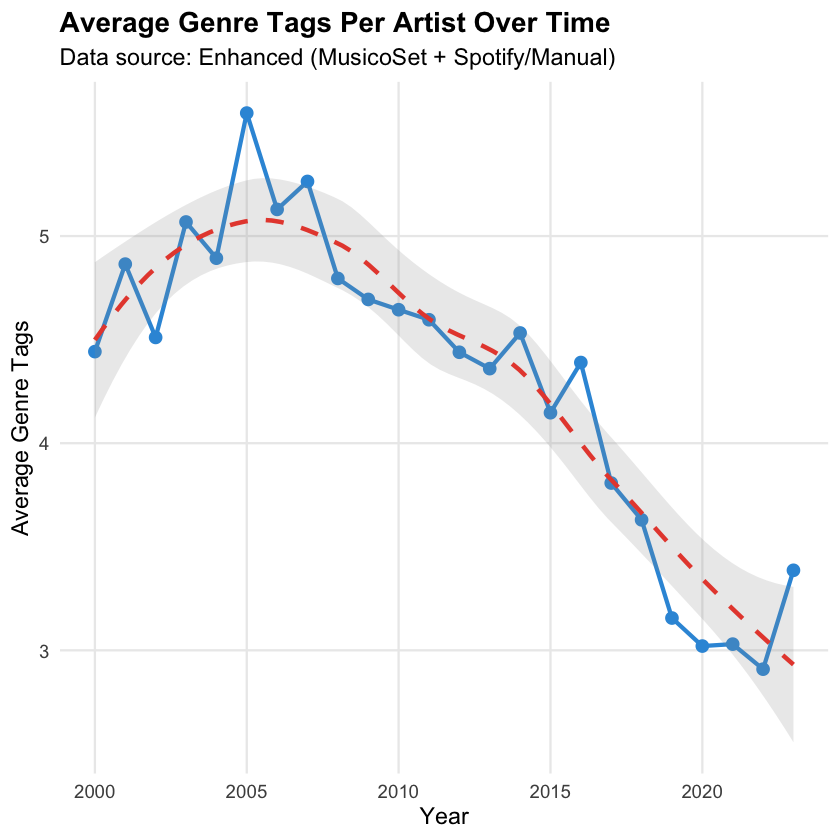

In [427]:
# Average Genre Tags Per Artist Over Time
# Uses enhanced data if available

# Load Billboard data
billboard <- read_csv('../../data/cleaned/billboard_24years_lyrics_spotify_bigquery.csv', show_col_types = FALSE)

# Load MusicoSet artist genres
musicoset <- read_csv('../../data/cleaned/musicoset_artists_cleaned.csv', show_col_types = FALSE)

# Count genres per artist from MusicoSet (genres are in "['pop', 'rock']" format)
musicoset_tags <- musicoset %>%
  filter(!is.na(genres) & genres != '') %>%
  mutate(
    n_genres = str_count(genres, "'") / 2  # Count genre entries
  ) %>%
  select(name, n_genres)

# Load supplementary data if exists
supplementary_file <- '../../data/cleaned/supplementary_artist_genres_final.csv'

if (file.exists(supplementary_file)) {
  supplementary <- read_csv(supplementary_file, show_col_types = FALSE)
  
  supplementary_tags <- supplementary %>%
    filter(!is.na(genres) & genres != '') %>%
    mutate(
      n_genres = str_count(genres, "'") / 2
    ) %>%
    select(name, n_genres)
  
  # Combine: supplementary takes priority over MusicoSet
  all_artist_tags <- musicoset_tags %>%
    filter(!name %in% supplementary_tags$name) %>%
    bind_rows(supplementary_tags)
  
  data_source <- 'Enhanced (MusicoSet + Spotify/Manual)'
} else {
  all_artist_tags <- musicoset_tags
  data_source <- 'MusicoSet Only'
}

# Join with Billboard to get yearly data
artist_tags_yearly <- billboard %>%
  select(band_singer, year) %>%
  distinct() %>%
  left_join(all_artist_tags, by = c('band_singer' = 'name')) %>%
  mutate(n_genres = ifelse(is.na(n_genres), 0, n_genres))

# Calculate average per year
avg_tags_by_year <- artist_tags_yearly %>%
  group_by(year) %>%
  summarize(
    avg_tags = mean(n_genres),
    median_tags = median(n_genres),
    total_artists = n(),
    artists_with_tags = sum(n_genres > 0),
    .groups = 'drop'
  )

# Plot
p_avg_tags <- ggplot(avg_tags_by_year, aes(x = year, y = avg_tags)) +
  geom_line(color = '#3498db', size = 1.2) +
  geom_point(color = '#3498db', size = 3) +
  geom_smooth(method = 'loess', se = TRUE, alpha = 0.2, color = '#e74c3c', linetype = 'dashed') +
  labs(
    title = 'Average Genre Tags Per Artist Over Time',
    subtitle = paste0('Data source: ', data_source),
    x = 'Year',
    y = 'Average Genre Tags'
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = 'bold'),
    panel.grid.minor = element_blank()
  )

print(p_avg_tags)

ggsave('../../outputs/genre_network/avg_genre_tags_per_artist.png', p_avg_tags,
       width = 12, height = 8, dpi = 150, bg = 'white')

# Print summary
cat("\nAverage Genre Tags by Year:\n")
print(avg_tags_by_year, n = 24)

## Investigating the Co-occurrence Drop

Why did co-occurrences drop 67% while unique artists only dropped slightly? Let's investigate all possible causes.

=== INVESTIGATION 1: Genre Tags Per Artist ===

# A tibble: 24 x 7
    year total_artists matched_artists match_rate avg_genre_tags
   <dbl>         <int>           <int>      <dbl>          <dbl>
 1  2000            95              77       81.1           5.02
 2  2001            96              82       85.4           5.19
 3  2002            94              77       81.9           5.43
 4  2003           103              90       87.4           5.34
 5  2004           103              90       87.4           5.12
 6  2005            96              86       89.6           6.01
 7  2006           101              89       88.1           5.47
 8  2007            91              77       84.6           5.61
 9  2008            88              78       88.6           5.33
10  2009            85              77       90.6           4.69
11  2010            90              83       92.2           4.82
12  2011            99              86       86.9           4.58
13  2012            82 

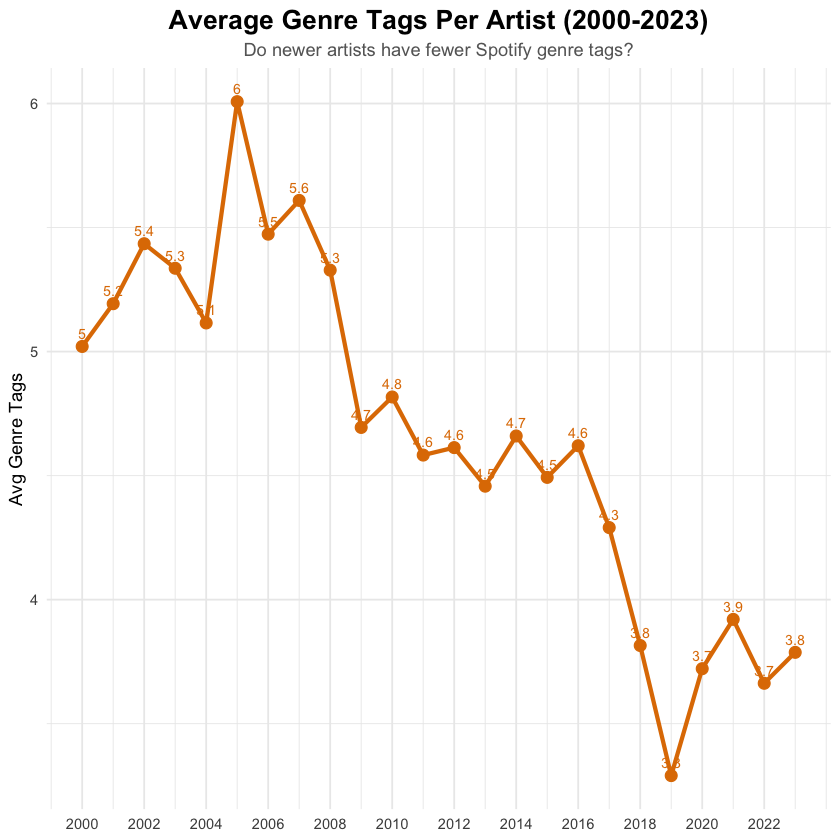

In [428]:
# Investigation 1: Genre Tags Per Artist Over Time
# Does MusicoSet have fewer genre tags for newer artists?

# Load MusicoSet artists data
musicoset_artists <- read_csv('../../data/cleaned/musicoset_artists_cleaned.csv', show_col_types = FALSE)

# Count genre tags per artist (genres column contains array like "['pop', 'dance pop']")
musicoset_artists <- musicoset_artists %>%
  mutate(
    # Count genres by counting commas + 1, or 0 if NA/empty
    genre_count = case_when(
      is.na(genres) | genres == "" | genres == "[]" ~ 0,
      TRUE ~ str_count(genres, ",") + 1
    )
  )

# Join Billboard with MusicoSet to get genre counts per year
billboard_with_genres <- billboard %>%
  left_join(
    musicoset_artists %>% select(name, genres, genre_count),
    by = c("band_singer" = "name")
  )

# Calculate stats per year
genre_tags_by_year <- billboard_with_genres %>%
  group_by(year) %>%
  summarize(
    total_artists = n_distinct(band_singer),
    matched_artists = n_distinct(band_singer[!is.na(genres)]),
    match_rate = matched_artists / total_artists * 100,
    avg_genre_tags = mean(genre_count, na.rm = TRUE),
    median_genre_tags = median(genre_count, na.rm = TRUE),
    total_genre_tags = sum(genre_count, na.rm = TRUE),
    .groups = 'drop'
  )

cat("=== INVESTIGATION 1: Genre Tags Per Artist ===\n\n")
print(genre_tags_by_year, n = 24)

# Plot: Average genre tags over time
p_genre_tags <- ggplot(genre_tags_by_year, aes(x = year, y = avg_genre_tags)) +
  geom_line(color = "#E07B00", linewidth = 1.2) +
  geom_point(color = "#E07B00", size = 3) +
  geom_text(aes(label = round(avg_genre_tags, 1)), vjust = -0.8, size = 3, color = "#E07B00") +
  scale_x_continuous(breaks = seq(2000, 2023, by = 2)) +
  labs(
    title = "Average Genre Tags Per Artist (2000-2023)",
    subtitle = "Do newer artists have fewer Spotify genre tags?",
    x = NULL, y = "Avg Genre Tags"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 11, color = "gray40")
  )

print(p_genre_tags)

=== INVESTIGATION 2: MusicoSet Matching Rate ===


Matching Details:
# A tibble: 24 x 4
    year total_artists matched_artists match_rate
   <dbl>         <int>           <int>      <dbl>
 1  2000            95              77       81.1
 2  2001            96              82       85.4
 3  2002            94              77       81.9
 4  2003           103              90       87.4
 5  2004           103              90       87.4
 6  2005            96              86       89.6
 7  2006           101              89       88.1
 8  2007            91              77       84.6
 9  2008            88              78       88.6
10  2009            85              77       90.6
11  2010            90              83       92.2
12  2011            99              86       86.9
13  2012            82              74       90.2
14  2013           100              89       89  
15  2014           109             101       92.7
16  2015           102              89       87.3
17  2016    

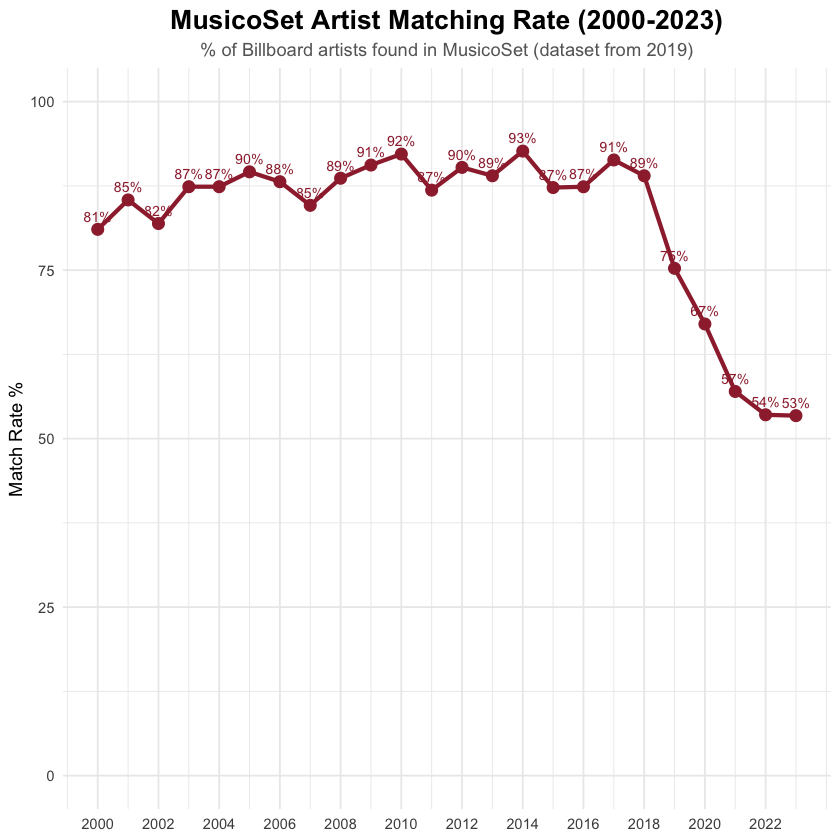

In [429]:
# Investigation 2: MusicoSet Matching Rate Over Time
# Does MusicoSet (from 2019) have worse coverage for newer artists?

cat("=== INVESTIGATION 2: MusicoSet Matching Rate ===\n\n")

# Plot: Match rate over time
p_match_rate <- ggplot(genre_tags_by_year, aes(x = year, y = match_rate)) +
  geom_line(color = "#9D2A3A", linewidth = 1.2) +
  geom_point(color = "#9D2A3A", size = 3) +
  geom_text(aes(label = paste0(round(match_rate, 0), "%")), vjust = -0.8, size = 3, color = "#9D2A3A") +
  scale_x_continuous(breaks = seq(2000, 2023, by = 2)) +
  scale_y_continuous(limits = c(0, 100)) +
  labs(
    title = "MusicoSet Artist Matching Rate (2000-2023)",
    subtitle = "% of Billboard artists found in MusicoSet (dataset from 2019)",
    x = NULL, y = "Match Rate %"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 11, color = "gray40")
  )

print(p_match_rate)

# Show the actual numbers
cat("\nMatching Details:\n")
genre_tags_by_year %>%
  select(year, total_artists, matched_artists, match_rate) %>%
  print(n = 24)

=== INVESTIGATION 3: Superstar Effect ===

Artist Concentration Over Time:
# A tibble: 24 x 7
    year unique_artists avg_songs_per_artist top5_share top10_share top_artist  
   <dbl>          <int>                <dbl>      <dbl>       <dbl> <chr>       
 1  2000             95                 1.21       10.4        19.1 "Christina ~
 2  2001             96                 1.30       12          20.8 "Destiny's ~
 3  2002             94                 1.43       14.9        25.4 "Ashanti"   
 4  2003            103                 1.38       12.7        23.2 "50 Cent"   
 5  2004            103                 1.37       14.2        23.4 "Alicia Key~
 6  2005             96                 1.46       16.4        27.1 "50 Cent"   
 7  2006            101                 1.40       12.8        22.7 "Chris Brow~
 8  2007             91                 1.56       19.7        30.3 "Justin Tim~
 9  2008             88                 1.58       22.3        33.1 "Lil Wayne" 
10  2009       

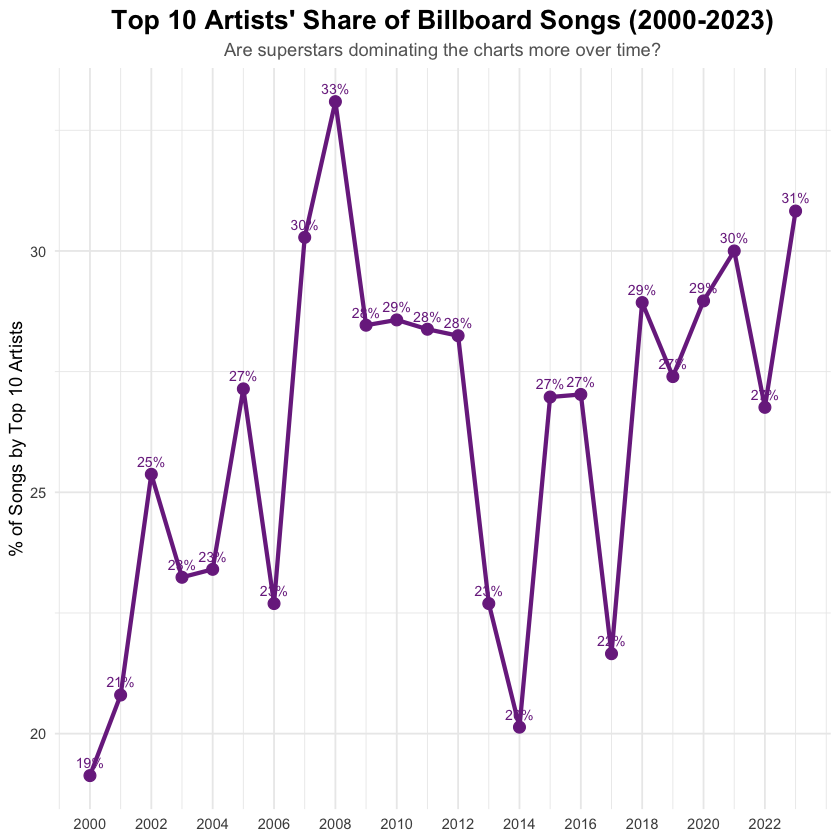

In [430]:
# Investigation 3: Superstar Effect (Artist Concentration)
# Are fewer artists dominating with more songs?

cat("=== INVESTIGATION 3: Superstar Effect ===\n\n")

# Count songs per artist per year
artist_songs_per_year <- billboard %>%
  group_by(year, band_singer) %>%
  summarize(songs = n(), .groups = 'drop')

# Calculate concentration metrics per year
concentration_by_year <- artist_songs_per_year %>%
  group_by(year) %>%
  summarize(
    total_songs = sum(songs),
    unique_artists = n(),
    avg_songs_per_artist = mean(songs),
    max_songs_by_one_artist = max(songs),
    top_artist = band_singer[which.max(songs)],
    # Top 5 artists' share
    top5_songs = sum(sort(songs, decreasing = TRUE)[1:min(5, n())]),
    top5_share = top5_songs / total_songs * 100,
    # Top 10 artists' share
    top10_songs = sum(sort(songs, decreasing = TRUE)[1:min(10, n())]),
    top10_share = top10_songs / total_songs * 100,
    .groups = 'drop'
  )

cat("Artist Concentration Over Time:\n")
concentration_by_year %>%
  select(year, unique_artists, avg_songs_per_artist, top5_share, top10_share, top_artist, max_songs_by_one_artist) %>%
  print(n = 24)

# Plot: Top 10 artist share over time
p_concentration <- ggplot(concentration_by_year, aes(x = year, y = top10_share)) +
  geom_line(color = "#7B2D8E", linewidth = 1.2) +
  geom_point(color = "#7B2D8E", size = 3) +
  geom_text(aes(label = paste0(round(top10_share, 0), "%")), vjust = -0.8, size = 3, color = "#7B2D8E") +
  scale_x_continuous(breaks = seq(2000, 2023, by = 2)) +
  labs(
    title = "Top 10 Artists' Share of Billboard Songs (2000-2023)",
    subtitle = "Are superstars dominating the charts more over time?",
    x = NULL, y = "% of Songs by Top 10 Artists"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 11, color = "gray40")
  )

print(p_concentration)

=== INVESTIGATION 4: Combined Analysis ===

All Metrics Indexed to 2000 = 100:
# A tibble: 24 x 6
    year artists_idx match_rate_idx avg_tags_idx total_tags_idx cooccurrence_idx
   <dbl>       <dbl>          <dbl>        <dbl>          <dbl>            <dbl>
 1  2000       100            100          100            100              100  
 2  2001       101.           105.         103.           122.             123. 
 3  2002        98.9          101.         108.           128.             113. 
 4  2003       108.           108.         106.           140.             147. 
 5  2004       108.           108.         102.           137.             141. 
 6  2005       101.           111.         120.           163.             154. 
 7  2006       106.           109.         109.           147.             132. 
 8  2007        95.8          104.         112.           147.             129. 
 9  2008        92.6          109.         106.           143.             100. 
10  2009   

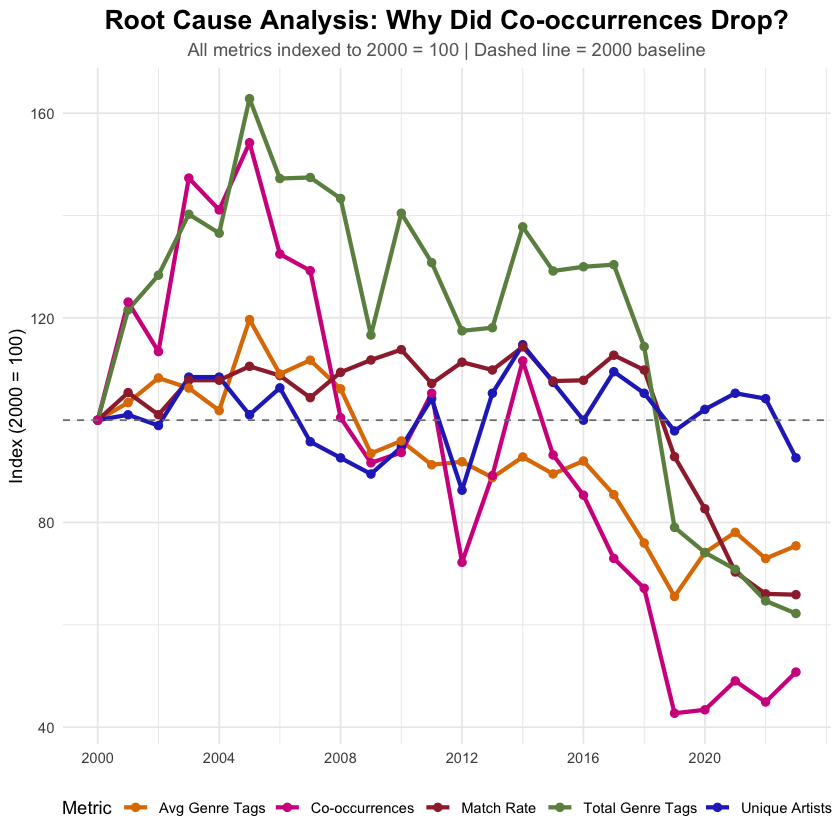

In [431]:
# Investigation 4: Combined Summary - All Factors Together
# Create a combined view to identify the root cause

cat("=== INVESTIGATION 4: Combined Analysis ===\n\n")

# Combine all metrics
combined_investigation <- genre_tags_by_year %>%
  select(year, total_artists, matched_artists, match_rate, avg_genre_tags, total_genre_tags) %>%
  left_join(cooccurrence_per_year, by = "year") %>%
  left_join(concentration_by_year %>% select(year, top10_share, avg_songs_per_artist), by = "year")

# Normalize all metrics to 2000 baseline for comparison
baseline_2000 <- combined_investigation %>% filter(year == 2000)

combined_normalized <- combined_investigation %>%
  mutate(
    artists_idx = total_artists / baseline_2000$total_artists * 100,
    match_rate_idx = match_rate / baseline_2000$match_rate * 100,
    avg_tags_idx = avg_genre_tags / baseline_2000$avg_genre_tags * 100,
    total_tags_idx = total_genre_tags / baseline_2000$total_genre_tags * 100,
    cooccurrence_idx = total_cooccurrences / baseline_2000$total_cooccurrences * 100,
    concentration_idx = top10_share / baseline_2000$top10_share * 100
  )

cat("All Metrics Indexed to 2000 = 100:\n")
combined_normalized %>%
  select(year, artists_idx, match_rate_idx, avg_tags_idx, total_tags_idx, cooccurrence_idx) %>%
  print(n = 24)

# Create combined plot with all factors
combined_long <- combined_normalized %>%
  select(year, 
         `Unique Artists` = artists_idx,
         `Match Rate` = match_rate_idx,
         `Avg Genre Tags` = avg_tags_idx,
         `Total Genre Tags` = total_tags_idx,
         `Co-occurrences` = cooccurrence_idx) %>%
  pivot_longer(-year, names_to = "metric", values_to = "index")

p_combined <- ggplot(combined_long, aes(x = year, y = index, color = metric)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 2) +
  geom_hline(yintercept = 100, linetype = "dashed", color = "gray50", linewidth = 0.5) +
  scale_x_continuous(breaks = seq(2000, 2023, by = 4)) +
  scale_color_manual(values = c(
    "Unique Artists" = "#2832C2",
    "Match Rate" = "#9D2A3A", 
    "Avg Genre Tags" = "#E07B00",
    "Total Genre Tags" = "#6B8E4E",
    "Co-occurrences" = "#d31f8eff"
  )) +
  labs(
    title = "Root Cause Analysis: Why Did Co-occurrences Drop?",
    subtitle = "All metrics indexed to 2000 = 100 | Dashed line = 2000 baseline",
    x = NULL, y = "Index (2000 = 100)",
    color = "Metric"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 11, color = "gray40"),
    legend.position = "bottom"
  )

print(p_combined)

ggsave('../../outputs/genre_network/cooccurrence_drop_investigation.png', p_combined,
       width = 14, height = 8, dpi = 300, bg = 'white')
cat("\nSaved cooccurrence_drop_investigation.png\n")

# Calculate correlation between factors and co-occurrences
cat("\n=== CORRELATION WITH CO-OCCURRENCES ===\n")
cat(sprintf("Unique Artists: r = %.3f\n", cor(combined_investigation$total_artists, combined_investigation$total_cooccurrences)))
cat(sprintf("Match Rate: r = %.3f\n", cor(combined_investigation$match_rate, combined_investigation$total_cooccurrences)))
cat(sprintf("Avg Genre Tags: r = %.3f\n", cor(combined_investigation$avg_genre_tags, combined_investigation$total_cooccurrences)))
cat(sprintf("Total Genre Tags: r = %.3f\n", cor(combined_investigation$total_genre_tags, combined_investigation$total_cooccurrences)))

# Summary
cat("\n=== ROOT CAUSE SUMMARY ===\n")
cat(sprintf("2000 → 2023 Changes:\n"))
final_row <- combined_normalized %>% filter(year == 2023)
cat(sprintf("  Unique Artists: %.0f%% of 2000 level\n", final_row$artists_idx))
cat(sprintf("  Match Rate: %.0f%% of 2000 level\n", final_row$match_rate_idx))
cat(sprintf("  Avg Genre Tags: %.0f%% of 2000 level\n", final_row$avg_tags_idx))
cat(sprintf("  Total Genre Tags: %.0f%% of 2000 level\n", final_row$total_tags_idx))
cat(sprintf("  Co-occurrences: %.0f%% of 2000 level\n", final_row$cooccurrence_idx))

In [432]:
# COMMENTED OUT - Spotify API and CSV creation cells
# These cells were used to create supplementary_artist_genres_final.csv
# The file already exists, so these don't need to run

if (FALSE) {
# Export Unmatched Artists for Manual Matching
# List all Billboard artists not found in MusicoSet

unmatched_artists <- billboard_with_genres %>%
  filter(is.na(genres)) %>%
  group_by(band_singer) %>%
  summarize(
    years_active = paste(sort(unique(year)), collapse = ", "),
    first_year = min(year),
    last_year = max(year),
    song_count = n(),
    sample_songs = paste(head(unique(song), 3), collapse = " | "),
    .groups = 'drop'
  ) %>%
  arrange(desc(song_count))

cat(sprintf("=== UNMATCHED ARTISTS: %d total ===\n\n", nrow(unmatched_artists)))

# Show summary by year range
cat("Unmatched by Era:\n")
unmatched_artists %>%
  mutate(era = case_when(
    last_year <= 2010 ~ "2000-2010",
    last_year <= 2015 ~ "2011-2015",
    last_year <= 2019 ~ "2016-2019",
    TRUE ~ "2020-2023"
  )) %>%
  count(era) %>%
  print()

cat("\n\nTop 50 Unmatched Artists (by song count):\n")
unmatched_artists %>% head(50) %>% print(n = 50)

# Export full list to CSV for manual matching
write_csv(unmatched_artists, '../../data/cleaned/unmatched_billboard_artists.csv')
cat(sprintf("\n\nExported full list to: data/cleaned/unmatched_billboard_artists.csv\n"))
cat("Columns: band_singer, years_active, first_year, last_year, song_count, sample_songs\n")
}

=== UNMATCHED ARTISTS: 271 total ===

Unmatched by Era:


# A tibble: 4 x 2
  era           n
  <chr>     <int>
1 2000-2010    79
2 2011-2015    40
3 2016-2019    28
4 2020-2023   124


Top 50 Unmatched Artists (by song count):
# A tibble: 50 x 6
   band_singer         years_active first_year last_year song_count sample_songs
   <chr>               <chr>             <dbl>     <dbl>      <int> <chr>       
 1 Jay-Z               2000, 2001,~       2000      2016         22 "Big Pimpin~
 2 Pink                2000, 2001,~       2000      2021         21 "There You ~
 3 Doja Cat            2020, 2021,~       2020      2023         17 "Say So | J~
 4 R. Kelly            2001, 2002,~       2001      2014         17 "Fiesta | C~
 5 DaBaby              2019, 2020,~       2019      2021         11 "Suge | Bab~
 6 Megan Thee Stallion 2019, 2020,~       2019      2022         10 "Cash Shit ~
 7 Juice Wrld          2018, 2019,~       2018      2020          8 "Lucid Drea~
 8 Pharrell            2002, 2003,~       2002      2007          7 "Pass the C~
 

## Fetch Missing Artist Genres from Spotify API

Use Spotify's API to get genre tags for artists not found in MusicoSet.

In [433]:
# COMMENTED OUT - Spotify API and CSV creation cells
# These cells were used to create supplementary_artist_genres_final.csv
# The file already exists, so these don't need to run

if (FALSE) {
# Spotify API Setup
# You'll need to set up credentials at https://developer.spotify.com/dashboard

# Install spotifyr if needed
if (!require(spotifyr)) {
  install.packages("spotifyr")
  library(spotifyr)
}

# Set your Spotify API credentials
# Get these from https://developer.spotify.com/dashboard
# Create an app and copy the Client ID and Client Secret

Sys.setenv(SPOTIFY_CLIENT_ID = 'b1867fcb53d64566a78deaae4d70a1c9')
Sys.setenv(SPOTIFY_CLIENT_SECRET = '2d35f732bcae440792e9e1bc308a6851')

# Authenticate
access_token <- get_spotify_access_token()

cat("Spotify API authenticated successfully!\n")
cat("Now run the next cell to fetch genres for unmatched artists.\n")
}

Spotify API authenticated successfully!
Now run the next cell to fetch genres for unmatched artists.


In [434]:
# COMMENTED OUT - Spotify API and CSV creation cells
# These cells were used to create supplementary_artist_genres_final.csv
# The file already exists, so these don't need to run

if (FALSE) {
# Fetch genres for unmatched artists from Spotify API

fetch_artist_genres <- function(artist_name) {
  tryCatch({
    # Search for artist
    search_result <- search_spotify(artist_name, type = "artist", limit = 1)
    
    if (nrow(search_result) == 0) {
      return(list(
        spotify_name = NA,
        spotify_id = NA,
        genres = NA,
        popularity = NA,
        match_status = "not_found"
      ))
    }
    
    # Get the top result
    artist <- search_result[1, ]
    
    return(list(
      spotify_name = artist$name,
      spotify_id = artist$id,
      genres = paste(unlist(artist$genres), collapse = ", "),
      popularity = artist$popularity,
      match_status = "found"
    ))
  }, error = function(e) {
    return(list(
      spotify_name = NA,
      spotify_id = NA,
      genres = NA,
      popularity = NA,
      match_status = paste("error:", e$message)
    ))
  })
}

# Get list of unmatched artists
artists_to_fetch <- unmatched_artists$band_singer

cat(sprintf("Fetching genres for %d unmatched artists from Spotify...\n", length(artists_to_fetch)))
cat("This may take a few minutes due to API rate limits.\n\n")

# Fetch genres with progress
results <- list()
for (i in seq_along(artists_to_fetch)) {
  artist <- artists_to_fetch[i]
  
  # Progress update every 20 artists
  if (i %% 20 == 0 || i == 1) {
    cat(sprintf("Processing %d/%d: %s\n", i, length(artists_to_fetch), artist))
  }
  
  results[[i]] <- fetch_artist_genres(artist)
  
  # Rate limiting - Spotify allows ~180 requests per minute
  Sys.sleep(0.35)
}

# Combine results into dataframe
spotify_genres <- tibble(
  billboard_name = artists_to_fetch,
  spotify_name = sapply(results, function(x) x$spotify_name),
  spotify_id = sapply(results, function(x) x$spotify_id),
  genres = sapply(results, function(x) x$genres),
  popularity = sapply(results, function(x) x$popularity),
  match_status = sapply(results, function(x) x$match_status)
)

# Join with original unmatched data
spotify_genres_full <- spotify_genres %>%
  left_join(unmatched_artists, by = c("billboard_name" = "band_singer"))

cat("\n=== FETCH COMPLETE ===\n")
cat(sprintf("Found: %d\n", sum(spotify_genres$match_status == "found")))
cat(sprintf("Not found: %d\n", sum(spotify_genres$match_status == "not_found")))
cat(sprintf("Errors: %d\n", sum(grepl("error", spotify_genres$match_status))))

# Show sample results
cat("\nSample results:\n")
spotify_genres_full %>%
  filter(match_status == "found") %>%
  select(billboard_name, spotify_name, genres, song_count) %>%
  head(20) %>%
  print(n = 20)
}

Fetching genres for 271 unmatched artists from Spotify...
This may take a few minutes due to API rate limits.

Processing 1/271: Jay-Z
Processing 20/271: Jack Harlow
Processing 40/271: Polo G
Processing 60/271: Giveon
Processing 80/271: Silk Sonic
Processing 100/271: BRS Kash
Processing 120/271: City Spud
Processing 140/271: Eslabon Armado
Processing 160/271: JP Saxe
Processing 180/271: Lil Boosie
Processing 200/271: M<U+00E5>neskin
Processing 220/271: QB Finest
Processing 240/271: Social House
Processing 260/271: Walk the Moon

=== FETCH COMPLETE ===
Found: 271
Not found: 0
Errors: 0

Sample results:
# A tibble: 20 x 4
   billboard_name      spotify_name        genres                     song_count
   <chr>               <chr>               <chr>                           <int>
 1 Jay-Z               JAY-Z               "hip hop, east coast hip ~         22
 2 Pink                Pink Floyd          "progressive rock, psyche~         21
 3 Doja Cat            Doja Cat            ""   

In [435]:
# COMMENTED OUT - Spotify API and CSV creation cells
# These cells were used to create supplementary_artist_genres_final.csv
# The file already exists, so these don't need to run

if (FALSE) {
# Export results and create manual mapping file

# Save Spotify results
write_csv(spotify_genres_full, '../../data/cleaned/spotify_genres_fetched.csv')
cat("Saved: data/cleaned/spotify_genres_fetched.csv\n")

# Create a mapping file that can be merged with MusicoSet format
# This includes both Spotify-fetched and still-missing artists

manual_mapping <- spotify_genres_full %>%
  mutate(
    # Convert genres to MusicoSet format: "['genre1', 'genre2']"
    genres_musicoset_format = case_when(
      is.na(genres) | genres == "" ~ NA_character_,
      TRUE ~ paste0("['", str_replace_all(genres, ", ", "', '"), "']")
    ),
    # Flag for manual review
    needs_review = case_when(
      match_status == "not_found" ~ "NOT_FOUND - needs manual entry",
      spotify_name != billboard_name ~ "NAME_MISMATCH - verify correct artist",
      genres == "" | is.na(genres) ~ "NO_GENRES - artist has no genre tags",
      TRUE ~ "OK"
    )
  ) %>%
  select(
    billboard_name,
    spotify_name,
    spotify_id,
    genres_original = genres,
    genres_musicoset_format,
    needs_review,
    song_count,
    years_active,
    sample_songs
  )

write_csv(manual_mapping, '../../data/cleaned/artist_genre_mapping.csv')
cat("Saved: data/cleaned/artist_genre_mapping.csv\n\n")

# Summary
cat("=== MAPPING FILE SUMMARY ===\n")
manual_mapping %>%
  count(needs_review) %>%
  print()

cat("\nNext steps:\n")
cat("1. Open data/cleaned/artist_genre_mapping.csv\n")
cat("2. Review entries marked 'NAME_MISMATCH' - verify Spotify found the right artist\n")
cat("3. For 'NOT_FOUND' entries, manually add genres in genres_musicoset_format column\n")
cat("4. For 'NO_GENRES' entries, either leave blank or manually add genres\n")
cat("5. Run the next cell to merge this data back into the analysis\n")
}

Saved: data/cleaned/spotify_genres_fetched.csv
Saved: data/cleaned/artist_genre_mapping.csv

=== MAPPING FILE SUMMARY ===
# A tibble: 3 x 2
  needs_review                              n
  <chr>                                 <int>
1 NAME_MISMATCH - verify correct artist    98
2 NO_GENRES - artist has no genre tags    115
3 OK                                       58

Next steps:
1. Open data/cleaned/artist_genre_mapping.csv
2. Review entries marked 'NAME_MISMATCH' - verify Spotify found the right artist
3. For 'NOT_FOUND' entries, manually add genres in genres_musicoset_format column
4. For 'NO_GENRES' entries, either leave blank or manually add genres
5. Run the next cell to merge this data back into the analysis


In [436]:
# COMMENTED OUT - Spotify API and CSV creation cells
# These cells were used to create supplementary_artist_genres_final.csv
# The file already exists, so these don't need to run

if (FALSE) {
# Merge Spotify genres back into analysis
# Run this after reviewing/editing artist_genre_mapping.csv

# Load the mapping file (with any manual edits you've made)
artist_mapping <- read_csv('../../data/cleaned/artist_genre_mapping.csv', show_col_types = FALSE)

# Filter to only valid entries
valid_mappings <- artist_mapping %>%
  filter(!is.na(genres_musicoset_format), genres_musicoset_format != "")

cat(sprintf("Valid genre mappings: %d out of %d artists\n", nrow(valid_mappings), nrow(artist_mapping)))

# Create supplementary artist data in MusicoSet format
supplementary_artists <- valid_mappings %>%
  transmute(
    name = billboard_name,
    genres = genres_musicoset_format,
    source = "spotify_api_2024"
  )

# Save as supplementary file
write_csv(supplementary_artists, '../../data/cleaned/supplementary_artist_genres.csv')
cat("Saved: data/cleaned/supplementary_artist_genres.csv\n\n")

# Show what we're adding
cat("Sample of supplementary artist genres:\n")
supplementary_artists %>% head(20) %>% print(n = 20)

cat("\n\nTo use these in the analysis:\n")
cat("1. The supplementary file is saved\n")
cat("2. Modify the data loading cells to also load supplementary_artist_genres.csv\n")
cat("3. Combine with musicoset_artists before joining with Billboard\n")
}

Valid genre mappings: 106 out of 271 artists
Saved: data/cleaned/supplementary_artist_genres.csv

Sample of supplementary artist genres:
# A tibble: 20 x 3
   name                   genres                                          source
   <chr>                  <chr>                                           <chr> 
 1 Jay-Z                  "['hip hop', 'east coast hip hop', 'rap']"      spoti~
 2 Pink                   "['progressive rock', 'psychedelic rock', 'cla~ spoti~
 3 R. Kelly               "['r&b']"                                       spoti~
 4 Juice Wrld             "['melodic rap', 'emo rap']"                    spoti~
 5 P. Diddy               "['hip hop', 'east coast hip hop']"             spoti~
 6 Pop Smoke              "['brooklyn drill', 'new york drill', 'drill']" spoti~
 7 Lainey Wilson          "['country']"                                   spoti~
 8 Ty Dolla Sign          "['trap soul']"                                 spoti~
 9 Young Jeezy            "['south

In [437]:
# COMMENTED OUT - Spotify API and CSV creation cells
# These cells were used to create supplementary_artist_genres_final.csv
# The file already exists, so these don't need to run

if (FALSE) {
# Handle artists with no genre tags
# 1. List all NO_GENRES artists by song count
# 2. Pre-fill likely genres based on patterns

# Load the mapping file
artist_mapping <- read_csv('../../data/cleaned/artist_genre_mapping.csv', show_col_types = FALSE)

# Find artists with no genres (found on Spotify but no tags)
no_genre_artists <- artist_mapping %>%
  filter(needs_review == "NO_GENRES - artist has no genre tags" | 
         (needs_review == "OK" & (is.na(genres_original) | genres_original == "")))

cat(sprintf("=== ARTISTS WITH NO GENRE TAGS: %d ===\n\n", nrow(no_genre_artists)))

# Also include NOT_FOUND artists
not_found_artists <- artist_mapping %>%
  filter(needs_review == "NOT_FOUND - needs manual entry")

cat(sprintf("Artists not found on Spotify: %d\n\n", nrow(not_found_artists)))

# Combine both for manual assignment
needs_manual <- bind_rows(
  no_genre_artists %>% mutate(issue = "no_genres"),
  not_found_artists %>% mutate(issue = "not_found")
) %>%
  arrange(desc(song_count))

# Pre-fill likely genres based on patterns in artist name and songs
suggest_genre <- function(artist_name, sample_songs) {
  artist_lower <- tolower(artist_name)
  songs_lower <- tolower(sample_songs)
  combined <- paste(artist_lower, songs_lower)
  
  # Pattern matching for likely genres
  suggestions <- c()
  
  # Hip Hop / Rap indicators
  if (grepl("feat\\.|ft\\.|featuring|lil |young |big |dj |rapper|yung ", combined)) {
    suggestions <- c(suggestions, "hip hop", "rap")
  }
  
  # Latin indicators
  if (grepl("latino|latina|reggaeton|spanish|mexico|puerto|cuba|salsa|bachata|daddy yankee|bad bunny|j balvin|ozuna|maluma", combined)) {
    suggestions <- c(suggestions, "latin", "reggaeton")
  }
  
  # K-pop indicators
  if (grepl("bts|blackpink|twice|exo|nct|stray kids|korean|k-pop|kpop|newjeans|aespa|itzy|txt|enhypen", combined)) {
    suggestions <- c(suggestions, "k-pop", "pop")
  }
  
  # Country indicators
  if (grepl("country|nashville|cowboy|truck|beer|whiskey|farm|dirt road", combined)) {
    suggestions <- c(suggestions, "country", "contemporary country")
  }
  
  # Rock indicators
  if (grepl("rock|punk|metal|guitar|band", combined)) {
    suggestions <- c(suggestions, "rock", "alternative rock")
  }
  
  # Electronic/EDM indicators
  if (grepl("dj |edm|house|techno|electronic|remix|beat|bass|drop", combined)) {
    suggestions <- c(suggestions, "electronic", "edm", "dance pop")
  }
  
  # R&B indicators
  if (grepl("r&b|soul|rnb|slow jam|baby |love song", combined)) {
    suggestions <- c(suggestions, "r&b", "urban contemporary")
  }
  
  # Pop (default for mainstream)
  if (length(suggestions) == 0) {
    suggestions <- c("pop", "dance pop")
  }
  
  return(paste(unique(suggestions), collapse = ", "))
}

# Apply suggestions
needs_manual <- needs_manual %>%
  rowwise() %>%
  mutate(
    suggested_genres = suggest_genre(billboard_name, sample_songs),
    suggested_musicoset_format = paste0("['", str_replace_all(suggested_genres, ", ", "', '"), "']")
  ) %>%
  ungroup()

cat("Top 30 artists needing manual genre assignment:\n")
needs_manual %>%
  select(billboard_name, song_count, years_active, sample_songs, issue, suggested_genres) %>%
  head(30) %>%
  print(n = 30, width = Inf)

# Export for manual review
write_csv(needs_manual, '../../data/cleaned/artists_needs_manual_genres.csv')
cat(sprintf("\n\nExported: data/cleaned/artists_needs_manual_genres.csv (%d artists)\n", nrow(needs_manual)))
cat("\nColumns include 'suggested_genres' and 'suggested_musicoset_format' as starting points.\n")
cat("Review and edit the suggestions, then save the file.\n")
}

=== ARTISTS WITH NO GENRE TAGS: 115 ===

Artists not found on Spotify: 0

Top 30 artists needing manual genre assignment:
# A tibble: 30 x 6
   billboard_name        song_count years_active          
   <chr>                      <dbl> <chr>                 
 1 "Doja Cat"                    17 2020, 2021, 2022, 2023
 2 "DaBaby"                      11 2019, 2020, 2021      
 3 "Megan Thee Stallion"         10 2019, 2020, 2021, 2022
 4 "Olivia Rodrigo"               6 2021, 2022, 2023      
 5 "Ice Spice"                    4 2023                  
 6 "Jack Harlow"                  4 2020, 2021, 2022      
 7 "Lizzo"                        4 2019, 2020, 2022      
 8 "Colby O'Donis"                3 2008, 2009            
 9 "Latto"                        3 2022, 2023            
10 "Polo G"                       3 2019, 2021, 2022      
11 "Rod Wave"                     3 2020, 2021            
12 "The Cataracs"                 3 2010, 2011            
13 "24kGoldn"                    

In [438]:
# COMMENTED OUT - Spotify API and CSV creation cells
# These cells were used to create supplementary_artist_genres_final.csv
# The file already exists, so these don't need to run

if (FALSE) {
# Merge all genre sources into final supplementary artist file
# Sources:
# 1. artist_genre_mapping_corrected.csv - Spotify API results with corrections
# 2. artists_with_genres.csv - Manually added genres for missing artists

# Load corrected Spotify mappings
spotify_corrected <- read_csv('../../data/cleaned/artist_genre_mapping_corrected.csv', show_col_types = FALSE) %>%
  filter(!is.na(genres_musicoset_format) & genres_musicoset_format != "") %>%
  select(name = billboard_name, genres = genres_musicoset_format) %>%
  mutate(source = "spotify_api")

cat(sprintf("Spotify API (corrected): %d artists with genres\n", nrow(spotify_corrected)))

# Load manually added genres
manual_genres <- read_csv('../../data/cleaned/artists_with_genres.csv', show_col_types = FALSE) %>%
  filter(!is.na(genres_musicoset_format) & genres_musicoset_format != "") %>%
  select(name = billboard_name, genres = genres_musicoset_format) %>%
  mutate(source = "manual")

cat(sprintf("Manually added: %d artists with genres\n", nrow(manual_genres)))

# Combine - manual takes priority over Spotify (in case of conflicts)
combined_supplementary <- bind_rows(
  manual_genres,  # First priority
  spotify_corrected %>% filter(!name %in% manual_genres$name)  # Add Spotify if not in manual
)

cat(sprintf("\nTotal supplementary artists: %d\n", nrow(combined_supplementary)))

# Check for duplicates
dupes <- combined_supplementary %>% count(name) %>% filter(n > 1)
if (nrow(dupes) > 0) {
  cat("\nWarning: Duplicate artists found:\n")
  print(dupes)
  # Keep first occurrence (manual takes priority)
  combined_supplementary <- combined_supplementary %>% distinct(name, .keep_all = TRUE)
  cat(sprintf("After dedup: %d artists\n", nrow(combined_supplementary)))
}

# Save final supplementary file
write_csv(combined_supplementary, '../../data/cleaned/supplementary_artist_genres_final.csv')
cat("\nSaved: data/cleaned/supplementary_artist_genres_final.csv\n")

# Show sample
cat("\nSample of combined supplementary data:\n")
combined_supplementary %>% head(20) %>% print(n = 20)

# Summary by source
cat("\nBy source:\n")
combined_supplementary %>% count(source) %>% print()
}

Spotify API (corrected): 105 artists with genres
Manually added: 94 artists with genres

Total supplementary artists: 199

Saved: data/cleaned/supplementary_artist_genres_final.csv

Sample of combined supplementary data:
# A tibble: 20 x 3
   name                genres                                      source
   <chr>               <chr>                                       <chr> 
 1 Doja Cat            ['pop rap', 'r&b', 'hip hop']               manual
 2 DaBaby              ['hip hop', 'rap', 'trap']                  manual
 3 Megan Thee Stallion ['hip hop', 'rap', 'southern hip hop']      manual
 4 Olivia Rodrigo      ['pop', 'pop rock', 'alternative pop']      manual
 5 Ice Spice           ['hip hop', 'bronx drill', 'rap']           manual
 6 Jack Harlow         ['hip hop', 'rap', 'pop rap']               manual
 7 Lizzo               ['pop', 'r&b', 'hip hop']                   manual
 8 Colby O'Donis       ['pop', 'r&b']                              manual
 9 Latto            

Original MusicoSet artists: 8368
Supplementary artists: 199
Enhanced total: 8567

=== MATCH RATE IMPROVEMENT ===
# A tibble: 24 x 7
    year total_artists matched_enhanced match_rate_enhanced matched_original
   <dbl>         <int>            <int>               <dbl>            <int>
 1  2000            95               90                94.7               77
 2  2001            96               93                96.9               82
 3  2002            94               87                92.6               77
 4  2003           103              101                98.1               90
 5  2004           103               98                95.1               90
 6  2005            96               92                95.8               86
 7  2006           101               97                96.0               89
 8  2007            91               85                93.4               77
 9  2008            88               86                97.7               78
10  2009            8

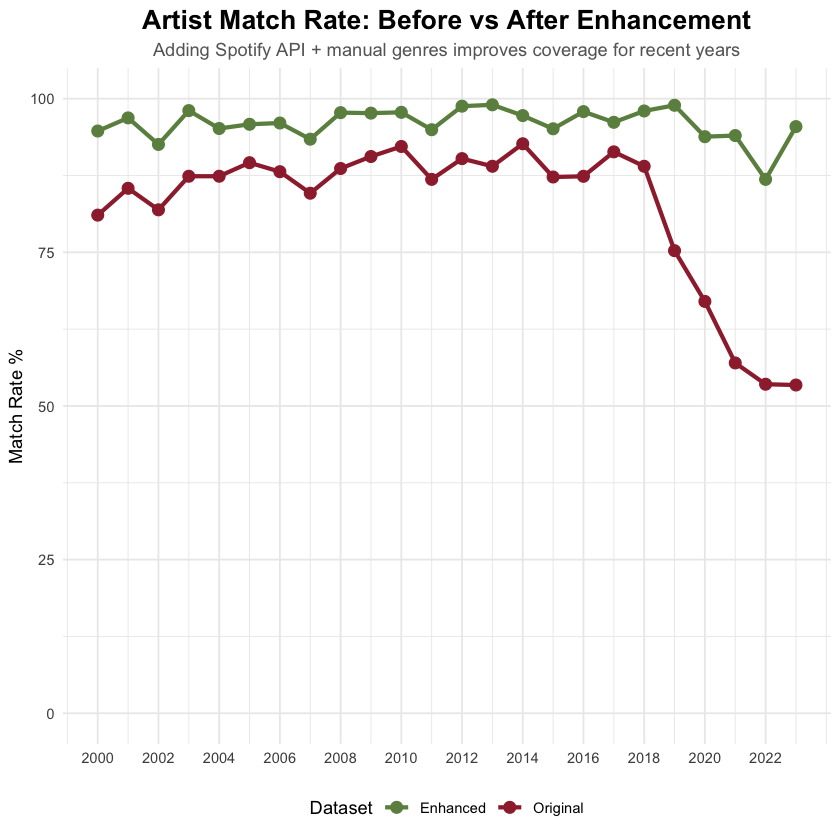

In [439]:
# COMMENTED OUT - Spotify API and CSV creation cells
# These cells were used to create supplementary_artist_genres_final.csv
# The file already exists, so these don't need to run

if (FALSE) {
# Re-calculate match rate with supplementary data included
# This shows the improvement from adding Spotify API + manual genres

# Load original MusicoSet
musicoset_original <- read_csv('../../data/cleaned/musicoset_artists_cleaned.csv', show_col_types = FALSE) %>%
  select(name, genres) %>%
  filter(!is.na(genres))

# Load supplementary
supplementary <- read_csv('../../data/cleaned/supplementary_artist_genres_final.csv', show_col_types = FALSE) %>%
  select(name, genres)

# Combine - supplementary takes priority
musicoset_enhanced <- bind_rows(
  supplementary,
  musicoset_original %>% filter(!name %in% supplementary$name)
)

cat(sprintf("Original MusicoSet artists: %d\n", nrow(musicoset_original)))
cat(sprintf("Supplementary artists: %d\n", nrow(supplementary)))
cat(sprintf("Enhanced total: %d\n", nrow(musicoset_enhanced)))

# Re-calculate match rate by year
billboard_enhanced <- billboard %>%
  left_join(
    musicoset_enhanced %>% 
      mutate(genre_count = str_count(genres, ",") + 1),
    by = c("band_singer" = "name")
  )

match_rate_comparison <- billboard_enhanced %>%
  group_by(year) %>%
  summarize(
    total_artists = n_distinct(band_singer),
    matched_enhanced = n_distinct(band_singer[!is.na(genres)]),
    match_rate_enhanced = matched_enhanced / total_artists * 100,
    .groups = 'drop'
  ) %>%
  left_join(
    genre_tags_by_year %>% select(year, matched_original = matched_artists, match_rate_original = match_rate),
    by = "year"
  ) %>%
  mutate(improvement = match_rate_enhanced - match_rate_original)

cat("\n=== MATCH RATE IMPROVEMENT ===\n")
match_rate_comparison %>% print(n = 24)

# Summary
cat(sprintf("\nOverall improvement:\n"))
cat(sprintf("  2019: %.1f%% → %.1f%% (+%.1f%%)\n", 
            match_rate_comparison$match_rate_original[match_rate_comparison$year == 2019],
            match_rate_comparison$match_rate_enhanced[match_rate_comparison$year == 2019],
            match_rate_comparison$improvement[match_rate_comparison$year == 2019]))
cat(sprintf("  2020: %.1f%% → %.1f%% (+%.1f%%)\n", 
            match_rate_comparison$match_rate_original[match_rate_comparison$year == 2020],
            match_rate_comparison$match_rate_enhanced[match_rate_comparison$year == 2020],
            match_rate_comparison$improvement[match_rate_comparison$year == 2020]))
cat(sprintf("  2021: %.1f%% → %.1f%% (+%.1f%%)\n", 
            match_rate_comparison$match_rate_original[match_rate_comparison$year == 2021],
            match_rate_comparison$match_rate_enhanced[match_rate_comparison$year == 2021],
            match_rate_comparison$improvement[match_rate_comparison$year == 2021]))
cat(sprintf("  2022: %.1f%% → %.1f%% (+%.1f%%)\n", 
            match_rate_comparison$match_rate_original[match_rate_comparison$year == 2022],
            match_rate_comparison$match_rate_enhanced[match_rate_comparison$year == 2022],
            match_rate_comparison$improvement[match_rate_comparison$year == 2022]))
cat(sprintf("  2023: %.1f%% → %.1f%% (+%.1f%%)\n", 
            match_rate_comparison$match_rate_original[match_rate_comparison$year == 2023],
            match_rate_comparison$match_rate_enhanced[match_rate_comparison$year == 2023],
            match_rate_comparison$improvement[match_rate_comparison$year == 2023]))

# Plot comparison
match_rate_long <- match_rate_comparison %>%
  select(year, Original = match_rate_original, Enhanced = match_rate_enhanced) %>%
  pivot_longer(-year, names_to = "dataset", values_to = "match_rate")

p_improvement <- ggplot(match_rate_long, aes(x = year, y = match_rate, color = dataset)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 3) +
  scale_color_manual(values = c("Original" = "#9D2A3A", "Enhanced" = "#6B8E4E")) +
  scale_x_continuous(breaks = seq(2000, 2023, by = 2)) +
  scale_y_continuous(limits = c(0, 100)) +
  labs(
    title = "Artist Match Rate: Before vs After Enhancement",
    subtitle = "Adding Spotify API + manual genres improves coverage for recent years",
    x = NULL, y = "Match Rate %", color = "Dataset"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 11, color = "gray40"),
    legend.position = "bottom"
  )

print(p_improvement)
ggsave('../../outputs/genre_network/match_rate_improvement.png', p_improvement,
       width = 12, height = 7, dpi = 300, bg = 'white')
cat("\nSaved: match_rate_improvement.png\n")
}

## Data Enhancement Comparison

Compare original BigQuery data vs enhanced data with supplementary artists.

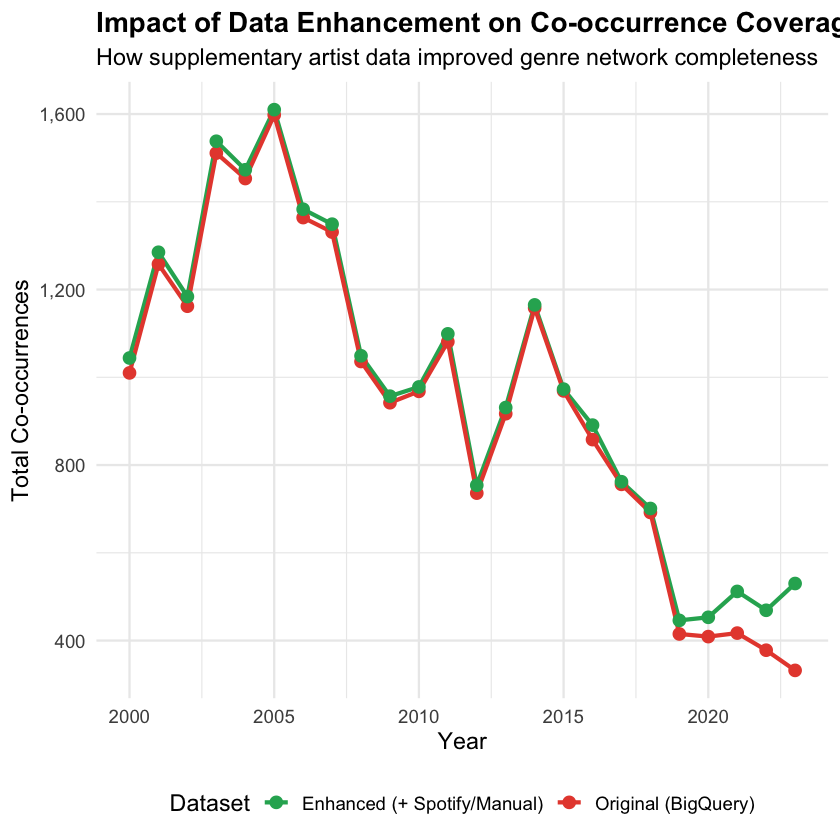

In [440]:
# Compare original vs enhanced co-occurrences over time

if (exists('temporal_edges_original')) {
  original_yearly <- temporal_edges_original %>%
    group_by(year) %>%
    summarize(cooccurrences = sum(weight), .groups = 'drop') %>%
    mutate(dataset = 'Original (BigQuery)')
  
  enhanced_yearly <- temporal_edges %>%
    group_by(year) %>%
    summarize(cooccurrences = sum(weight), .groups = 'drop') %>%
    mutate(dataset = 'Enhanced (+ Spotify/Manual)')
  
  comparison <- bind_rows(original_yearly, enhanced_yearly)
  
  p_comparison <- ggplot(comparison, aes(x = year, y = cooccurrences, color = dataset)) +
    geom_line(size = 1.2) +
    geom_point(size = 3) +
    scale_color_manual(values = c('Original (BigQuery)' = '#e74c3c', 
                                   'Enhanced (+ Spotify/Manual)' = '#27ae60')) +
    scale_y_continuous(labels = scales::comma) +
    labs(
      title = 'Impact of Data Enhancement on Co-occurrence Coverage',
      subtitle = 'How supplementary artist data improved genre network completeness',
      x = 'Year',
      y = 'Total Co-occurrences',
      color = 'Dataset'
    ) +
    theme_minimal(base_size = 14) +
    theme(
      plot.title = element_text(face = 'bold'),
      legend.position = 'bottom'
    )
  
  print(p_comparison)
  
  ggsave('../../outputs/genre_network/data_enhancement_impact.png', p_comparison,
         width = 12, height = 8, dpi = 150, bg = 'white')
} else {
  cat("No original data to compare (supplementary data was not loaded).\n")
}